In [649]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from os import listdir
import seaborn as sns
from scipy import stats
import datetime as dt

font_size = 30
font_size_ticks = 25

np.set_printoptions(precision=3)

In [ ]:
def create_data_matrix(str_path):
    file_name_list = listdir(str_path)
    file_name_list.sort()
    col_ind_date = 3
    col_ind_time = 4
    col_ind_temperature = 8
    time_matrix = []
    date_matrix = []
    data_matrix = []
    ind = 0
    for file_name in file_name_list:
        if file_name[0] == '.':
            continue
        else:
            print("Station " + str(ind))
            print(file_name)
            ind = ind + 1
            data_aux = np.loadtxt(str_path + file_name, usecols=range(14))
            data = data_aux[:,col_ind_temperature]
            date = data_aux[:,col_ind_date]
            time = data_aux[:,col_ind_time]
            if len(data_matrix) == 0:
                data_matrix = data
                time_matrix = time
                date_matrix = date
            else:
                data_matrix = np.vstack((data_matrix,data))
                time_matrix = np.vstack((time_matrix,time))
                date_matrix = np.vstack((date_matrix,date))
    return [data_matrix.T,time_matrix.T,date_matrix.T]

def process_name(x):
    x = x[14:]
    x = x[:-7]
    x = x.translate(str.maketrans('','','_1234567890'))
    return x[2:] + ", " + x[:2]

str_path = "../data/weather/"

load_files = True
str_path_2015 = str_path + "hourly/2015/"
str_path_2016 = str_path + "hourly/2016/"
file_name_2015 = str_path + "temperatures_2015_new.npy"
file_name_2016 = str_path + "temperatures_2016_new.npy"
file_name_2015_time = str_path + "times_2015.npy"
file_name_2016_time = str_path + "times_2016.npy"
file_name_2015_date = str_path + "dates_2015.npy"
file_name_2016_date = str_path + "dates_2016.npy"

if load_files:
    [data_matrix_2015,time_matrix_2015,date_matrix_2015] = create_data_matrix(str_path_2015)
    [data_matrix_2016,time_matrix_2016,date_matrix_2016] = create_data_matrix(str_path_2016)
    np.save(file_name_2015,data_matrix_2015)
    np.save(file_name_2016,data_matrix_2016)
    np.save(file_name_2015_time,time_matrix_2015)
    np.save(file_name_2016_time,time_matrix_2016)
    np.save(file_name_2015_date,date_matrix_2015)
    np.save(file_name_2016_date,date_matrix_2016)
else:
    data_matrix_2015 = np.load(file_name_2015)
    data_matrix_2016 = np.load(file_name_2016)

file_name_list = listdir(str_path + "hourly/2015/")
file_name_list.sort()

for ind,name in enumerate(file_name_list):
    print(ind)
    print(name)

print(data_matrix_2015.shape)
print(data_matrix_2016.shape)

In [624]:
station = 52 # Manhattan# 76 Durham # 118 Muleshoe # 52 Manhattan # 38 Sebring
name = process_name(file_name_list[station]) # CAREFUL: list may start at 1
print(name)

Manhattan, KS


In [625]:
def remove_faulty_measurements(data,verbose):
    min_val = -100 # We assume temperatures cannot be lower than -100
    for ind in range(len(data)):
        median = np.median(data[data > min_val])
        if data[ind] < min_val:
            if verbose:
                print(str(ind) + ": " + str(data[ind]))
            aux_ind = ind-1
            while aux_ind > 0:
                if data[aux_ind] > min_val:
                    data[ind] = data[aux_ind]
                    print("changed to entry " + str(aux_ind) + ": " + str(data[ind]))
                    break
                else:
                    ind -= 1
    return data

verbose = True
temperature_2015 = remove_faulty_measurements(data_matrix_2015[:,station],verbose)
n_2015 = len(temperature_2015)
temperature_2016 = remove_faulty_measurements(data_matrix_2016[:,station],verbose)
n_2016 = len(temperature_2016)

In [626]:
hour_2015 = (time_matrix_2015[:,station]/100).astype(int)
hour_2016 = (time_matrix_2016[:,station]/100).astype(int)

day_2015 = np.array([dt.datetime.strptime(str(int(date)), '%Y%m%d').timetuple().tm_yday for date in date_matrix_2015[:,station]])
day_2016 = np.array([dt.datetime.strptime(str(int(date)), '%Y%m%d').timetuple().tm_yday for date in date_matrix_2016[:,station]])

n_data_366 = np.sum(day_2016==366)
print(n_data_366)
temperature_2016 = temperature_2016[:-n_data_366]
day_2016 = day_2016[:-n_data_366]
hour_2016 = hour_2016[:-n_data_366]

19


In [627]:
n_days = 365
n_hours = 24

print(temperature_2015[(hour_2015 == 19) & (day_2015 == 12)])

temperature_grid_2015 = np.zeros((n_hours,n_days))
temperature_grid_2016 = np.zeros((n_hours,n_days))
for h in np.arange(0,n_hours,1):
    for m in np.arange(1,n_days+1,1):
        temperature_grid_2015[h,m-1] = np.mean(temperature_2015[(hour_2015 == h) & (day_2015 == m)])
        temperature_grid_2016[h,m-1] = np.mean(temperature_2016[(hour_2016 == h) & (day_2016 == m)])
max_mean_temp_2015 = np.max(temperature_grid_2015)
max_mean_temp_2016 = np.max(temperature_grid_2016)
max_mean_temp = np.max(np.array([max_mean_temp_2015,max_mean_temp_2016]))
min_mean_temp_2015 = np.min(temperature_grid_2015)
min_mean_temp_2016 = np.min(temperature_grid_2016)
min_mean_temp = np.min(np.array([min_mean_temp_2015,min_mean_temp_2016]))
print(max_mean_temp)
print(min_mean_temp)

[-6.]
38.9
-26.4


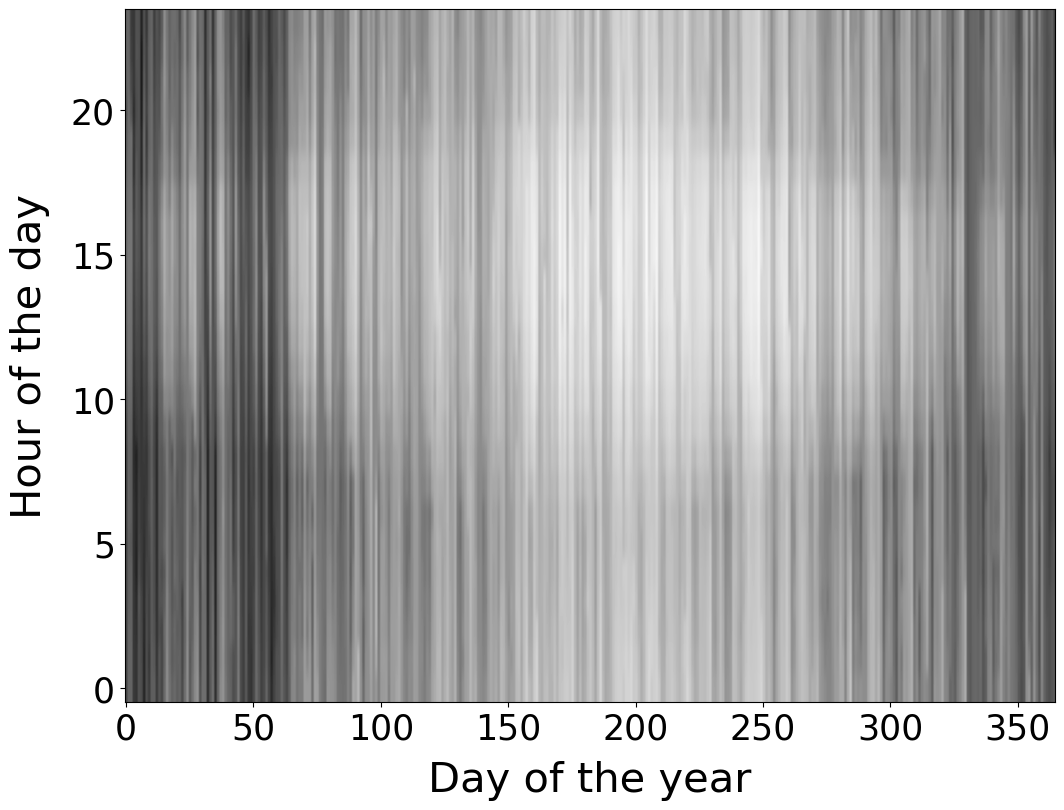

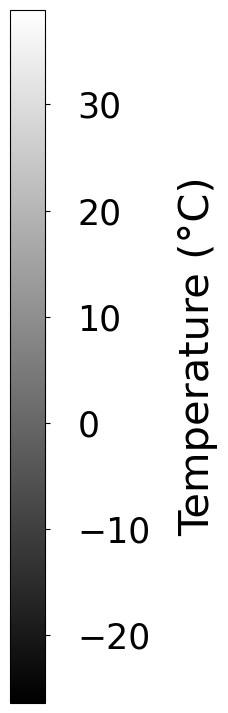

In [657]:
figsize = (12,9)
plt.figure(figsize = (12,9)) 
im = plt.imshow(temperature_grid_2015, cmap='gray', vmin=min_mean_temp, vmax=max_mean_temp,
                #extent=[0,n_hours,1, n_months+1],
                origin='lower', aspect='auto')
# cbar = plt.colorbar(im)
# cbar.ax.tick_params(labelsize=font_size_ticks,pad = 20)
# cbar.set_label(label='Temperature (°C)',fontsize=font_size,labelpad = 20)
plt.xticks(fontsize=font_size_ticks)
plt.yticks(fontsize=font_size_ticks) 
plt.xlabel('Day of the year',fontsize=font_size,labelpad = 10)
plt.ylabel('Hour of the day',fontsize=font_size,labelpad = 15)
plt.savefig('plots/tree_temp_data_2015.pdf',bbox_inches="tight")

fig,ax = plt.subplots(figsize=(9,9))
cbar = plt.colorbar(im,ax=ax)
# cbar.ax.set_ylim(0, 1.0)
cbar.ax.tick_params(labelsize=font_size_ticks,pad = 20)
cbar.set_label(label='Temperature (°C)',fontsize=font_size,labelpad = 20)
ax.remove()
plt.savefig('plots/tree_temp_colorbar.pdf',bbox_inches="tight")

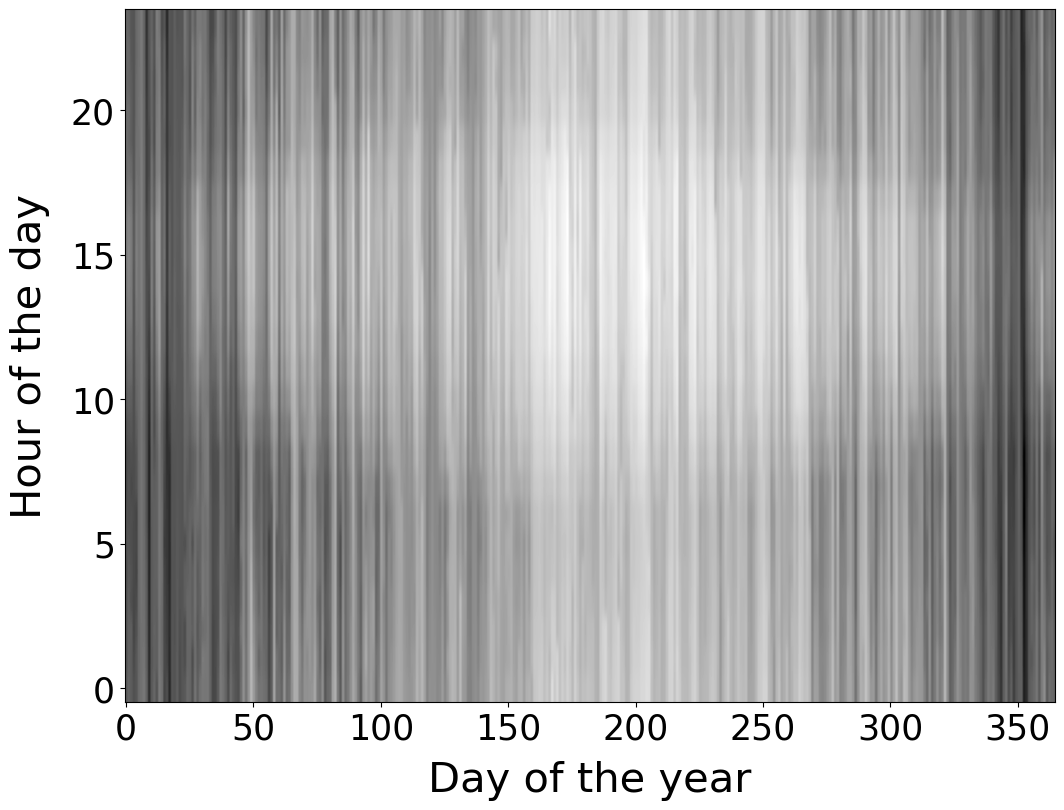

In [658]:
plt.figure(figsize = figsize) 
im = plt.imshow(temperature_grid_2016, cmap='gray', vmin=min_mean_temp, vmax=max_mean_temp,
                    #extent=[0,n_hours,0, n_months],
                    origin='lower', aspect='auto')
# cbar = plt.colorbar(im)
# cbar.ax.tick_params(labelsize=font_size_ticks,pad = 20)
# cbar.set_label(label='Temperature (°C)',fontsize=font_size,labelpad = 20)
plt.xticks(fontsize=font_size_ticks)
plt.yticks(fontsize=font_size_ticks) 
plt.xlabel('Day of the year',fontsize=font_size,labelpad = 10)
plt.ylabel('Hour of the day',fontsize=font_size,labelpad = 15)
plt.savefig('plots/tree_temp_data_2016.pdf',bbox_inches="tight")

In [630]:
X = np.array([hour_2015,day_2015]).T
linear_model = LinearRegression().fit(X, temperature_2015)

In [631]:
print("Coefficients: " + str(linear_model.coef_))
print("Intercept: " + str(linear_model.intercept_))
linear_prediction_2015 = linear_model.predict(X)
rmse_linear_2015 = np.sqrt(np.sum((temperature_2015-linear_prediction_2015)**2)/n_2015)
X_2016 = np.array([hour_2016,day_2016]).T
linear_prediction_2016 = linear_model.predict(X_2016)
rmse_linear_2016 = np.sqrt(np.sum((temperature_2016-linear_prediction_2016)**2)/n_2016)
print("Linear RMSE 2015",rmse_linear_2015)
print("Linear RMSE 2016",rmse_linear_2016)
# print("r2",linear_model.score(X,temperature_2015))

Coefficients: [0.24999 0.02774]
Intercept: 5.481502125044069
Linear RMSE 2015 10.809342980267603
Linear RMSE 2016 10.97172921905734


In [632]:
linear_prediction_grid = np.zeros((n_hours,n_days))
for h in np.arange(0,n_hours,1):
    for m in np.arange(1,n_days+1,1):
        linear_prediction_grid[h,m-1] = linear_model.predict(np.array([h,m]).reshape(1, -1))

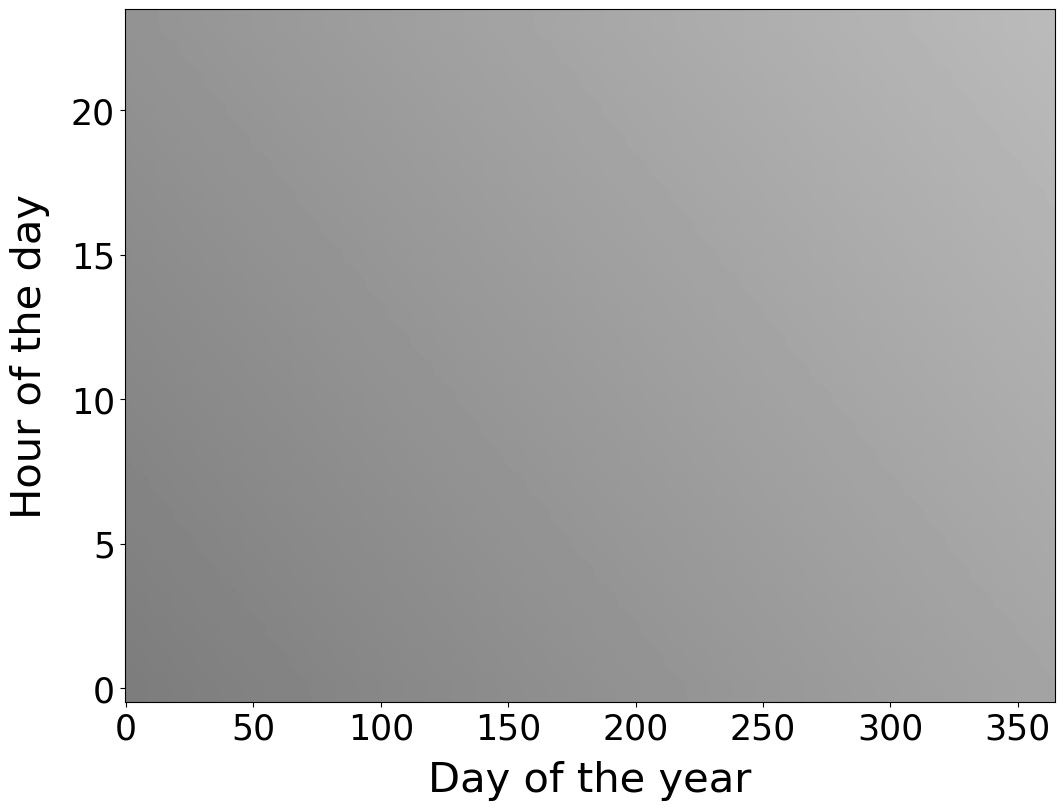

In [660]:
plt.figure(figsize = figsize) 
im = plt.imshow(linear_prediction_grid, cmap='gray', vmin=min_mean_temp, vmax=max_mean_temp,
                    #extent=[0,n_hours,0, n_months],
                    origin='lower', aspect='auto')
# cbar = plt.colorbar(im)
# cbar.ax.tick_params(labelsize=font_size_ticks,pad = 20)
# cbar.set_label(label='Temperature (°C)',fontsize=font_size,labelpad = 20)
plt.xticks(fontsize=font_size_ticks)
plt.yticks(fontsize=font_size_ticks) 
plt.xlabel('Day of the year',fontsize=font_size,labelpad = 10)
plt.ylabel('Hour of the day',fontsize=font_size,labelpad = 15)
plt.savefig('plots/tree_temp_linear.pdf',bbox_inches="tight")

In [671]:
def inds_region(r):
    return ( (day_2015 >= r["day_lims"][0]) & (day_2015 <= r["day_lims"][1]) 
                             & (hour_2015 >= r["hour_lims"][0]) & (hour_2015 <= r["hour_lims"][1]) )

def tree_estimate(regions,save_str,verbose):
    err_2015 = 0
    err_2016 = 0
    n_regions = len(regions)
    estimate_grid = np.zeros((n_hours,n_days))
    for ind_r,r in enumerate(regions):
        inds_region_2015 = inds_region(r)
        temp_region_2015 = temperature_2015[inds_region_2015]
        inds_region_2016 = ( (day_2016 >= r["day_lims"][0]) & (day_2016 <= r["day_lims"][1]) 
                             & (hour_2016 >= r["hour_lims"][0]) & (hour_2016 <= r["hour_lims"][1]) )
        temp_region_2016 = temperature_2016[inds_region_2016]
        est_region = np.mean(temp_region_2015)
        err_2015 = err_2015 + np.sum( (temp_region_2015 - est_region)**2 )
        err_2016 = err_2016 + np.sum( (temp_region_2016 - est_region)**2 )
        estimate_grid[r["hour_lims"][0]:(r["hour_lims"][1]+1),(r["day_lims"][0]-1):r["day_lims"][1]] = est_region
    
    plt.figure(figsize = figsize) 
    im = plt.imshow(estimate_grid, cmap='gray', vmin=min_mean_temp, vmax=max_mean_temp,
                    origin='lower', aspect='auto')
#     cbar = plt.colorbar(im)
#     cbar.ax.tick_params(labelsize=font_size_ticks,pad = 20)
#     cbar.set_label(label='Temperature (°C)',fontsize=font_size,labelpad = 20)
    plt.xticks(fontsize=font_size_ticks)
    plt.yticks(fontsize=font_size_ticks) 
    plt.xlabel('Day of the year',fontsize=font_size,labelpad = 10)
    plt.ylabel('Hour of the day',fontsize=font_size,labelpad = 15)
    plt.savefig('plots/tree_temp_'+save_str+'.pdf',bbox_inches="tight")
    
    MSE_2015 = err_2015 / n_2015
    MSE_2016 = err_2016 / n_2016
    return [MSE_2015,MSE_2016]

In [672]:
def plot_regions(lines,save_str):
    plt.figure(figsize = figsize) 
    im = plt.imshow(temperature_grid_2015, cmap='gray', vmin=min_mean_temp, vmax=max_mean_temp,
                    #extent=[0,n_hours,1, n_days+1],
                    origin='lower', aspect='auto')
    for line in lines:
        if line[0] == "day":
            plt.vlines(line[1]-1.5,line[2]-0.5,line[3]+0.5,ls='dashed',color='white',lw=5)
        else:
            plt.hlines(line[1]-0.5,line[2]-1.5,line[3]-0.5,ls='dashed',color='white',lw=5)
#     cbar = plt.colorbar(im)
#     cbar.ax.tick_params(labelsize=font_size_ticks,pad = 20)
#     cbar.set_label(label='Temperature (°C)',fontsize=font_size,labelpad = 20)
    plt.xticks(fontsize=font_size_ticks)
    plt.yticks(fontsize=font_size_ticks) 
    plt.xlabel('Day of the year',fontsize=font_size,labelpad = 10)
    plt.ylabel('Hour of the day',fontsize=font_size,labelpad = 15)
    plt.ylim([0-0.5,n_hours-0.5])
    plt.xlim([0-0.5,n_days-0.5])
    plt.savefig('plots/tree_temp_lines_'+save_str+'.pdf',bbox_inches="tight")

In [673]:
def find_split(feature,data,possible_thresholds, verbose=True):
    err_vals = np.zeros(len(possible_thresholds))
    best_thresh = 0
    best_err = -1
    for ind,thresh in enumerate(possible_thresholds):
        left_split = data[feature < thresh]
        right_split = data[feature >= thresh]
        estimate_right_split = np.mean(right_split)
        if len(left_split)>0:
            estimate_left_split = np.mean(left_split)
            err_vals[ind] = np.sum((left_split-estimate_left_split)**2) + np.sum((right_split-estimate_right_split)**2)
        else:
            err_vals[ind] = np.sum((right_split-estimate_right_split)**2)
        if verbose:
            print(thresh)
            print("left split: ",len(left_split))
            print("right split: ",len(right_split))
            if len(left_split)>0:
                print("estimate left split: ",estimate_left_split)
            print("estimate right split: ",estimate_right_split)
            print("squared error: ",err_vals[ind])
    return err_vals

First region
Estimate 13.43348173515982
Split 1
Region to split {'day_lims': [1, 365], 'hour_lims': [0, 23]}
Feature day
Threshold 66
New left region {'day_lims': [1, 65], 'hour_lims': [0, 23]}
Estimate -1.3670512820512817
New right region {'day_lims': [66, 365], 'hour_lims': [0, 23]}
Estimate 16.64026388888889
Split 2
Region to split {'day_lims': [66, 365], 'hour_lims': [0, 23]}
Feature day
Threshold 297
New left region {'day_lims': [66, 296], 'hour_lims': [0, 23]}
Estimate 19.617478354978353
New right region {'day_lims': [297, 365], 'hour_lims': [0, 23]}
Estimate 6.673067632850242
Split 3
Region to split {'day_lims': [66, 296], 'hour_lims': [0, 23]}
Feature day
Threshold 145
New left region {'day_lims': [66, 144], 'hour_lims': [0, 23]}
Estimate 13.74746835443038
New right region {'day_lims': [145, 296], 'hour_lims': [0, 23]}
Estimate 22.668338815789475
Split 4
Region to split {'day_lims': [145, 296], 'hour_lims': [0, 23]}
Feature hour
Threshold 9
New left region {'day_lims': [145, 29

/var/folders/1r/8drxnfc95_q25t4qy8ng2md80000gn/T/ipykernel_15247/978930389.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = figsize)


Split 11
Region to split {'day_lims': [66, 144], 'hour_lims': [0, 9]}
Feature day
Threshold 90
New left region {'day_lims': [66, 89], 'hour_lims': [0, 9]}
Estimate 5.641249999999999
New right region {'day_lims': [90, 144], 'hour_lims': [0, 9]}
Estimate 12.266545454545454
Split 12
Region to split {'day_lims': [330, 365], 'hour_lims': [0, 23]}
Feature day
Threshold 361
New left region {'day_lims': [330, 360], 'hour_lims': [0, 23]}
Estimate 4.063709677419355
New right region {'day_lims': [361, 365], 'hour_lims': [0, 23]}
Estimate -3.779166666666667
Split 13
Region to split {'day_lims': [1, 65], 'hour_lims': [10, 23]}
Feature day
Threshold 14
New left region {'day_lims': [1, 13], 'hour_lims': [10, 23]}
Estimate -4.43956043956044
New right region {'day_lims': [14, 65], 'hour_lims': [10, 23]}
Estimate 2.0548076923076923
Split 14
Region to split {'day_lims': [14, 65], 'hour_lims': [10, 23]}
Feature day
Threshold 42
New left region {'day_lims': [14, 41], 'hour_lims': [10, 23]}
Estimate 5.50229

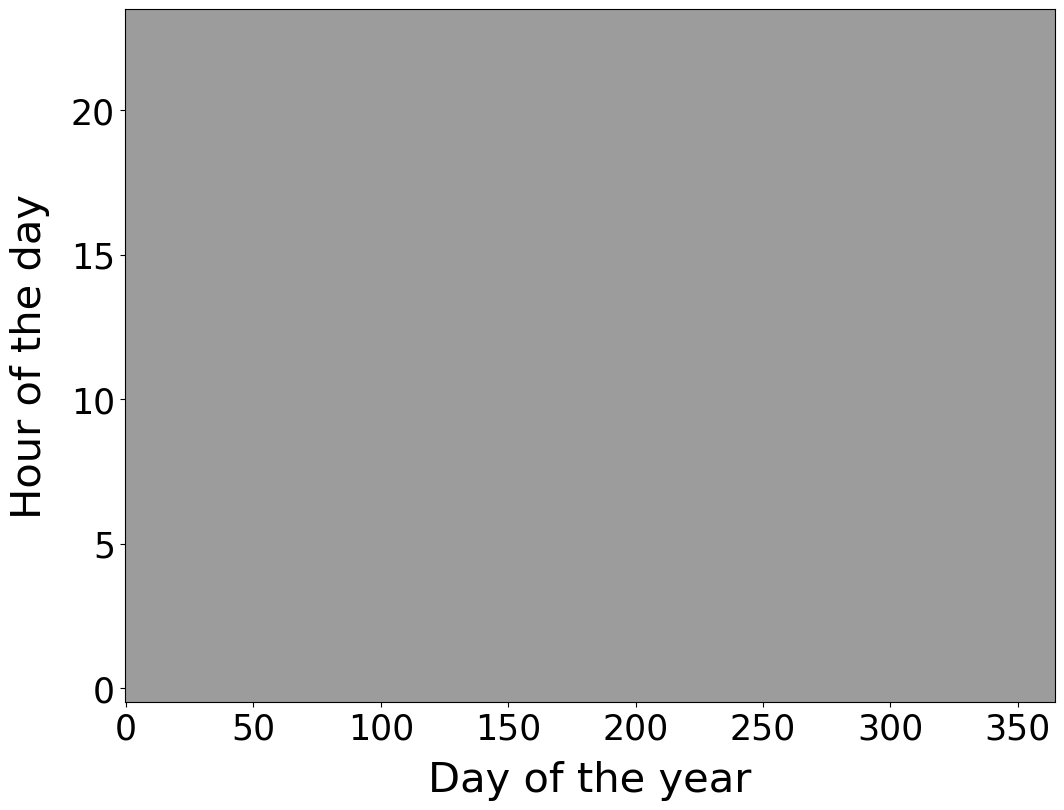

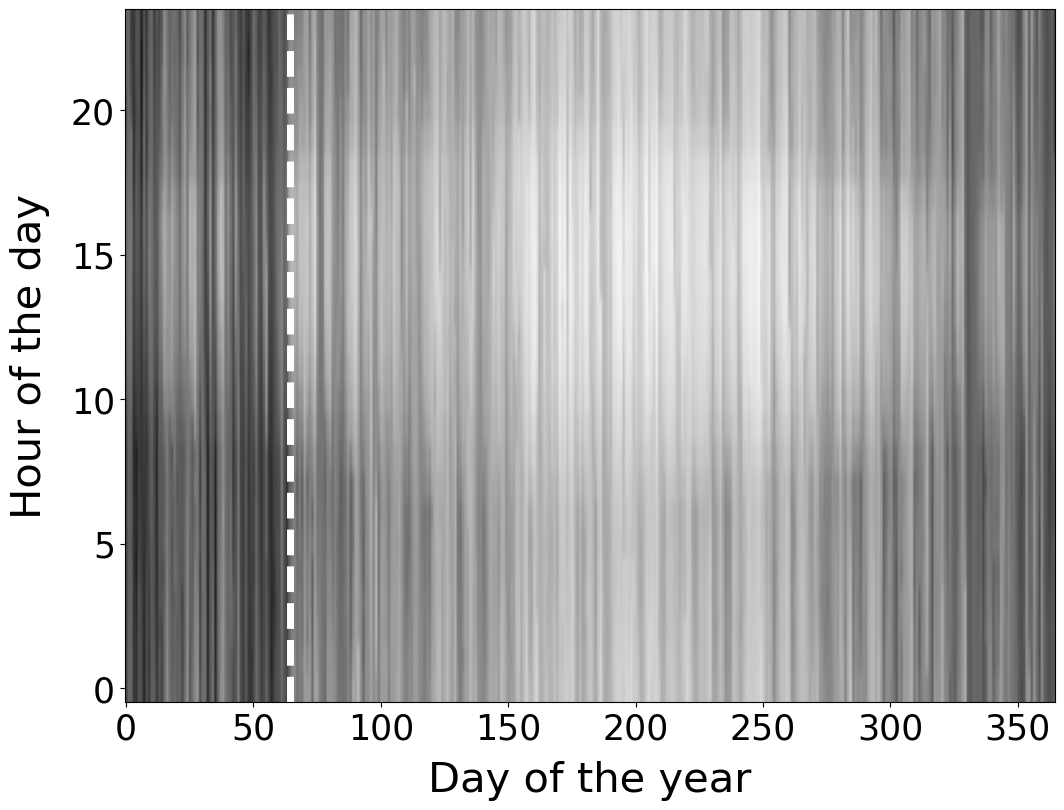

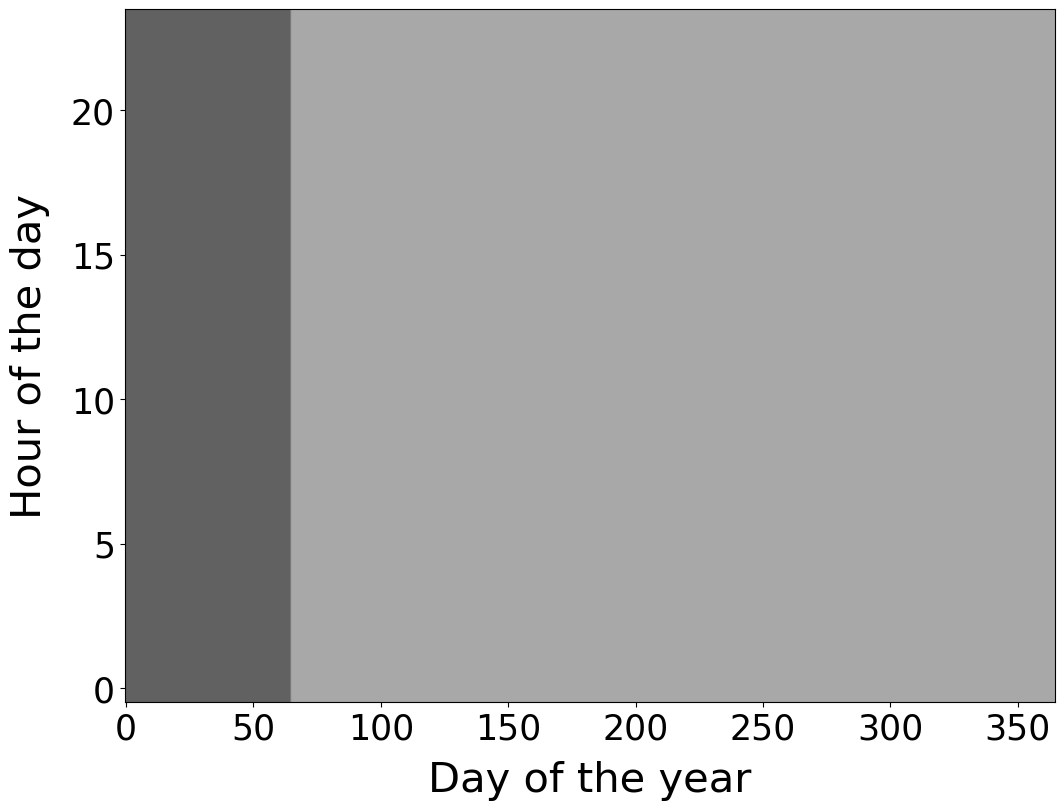

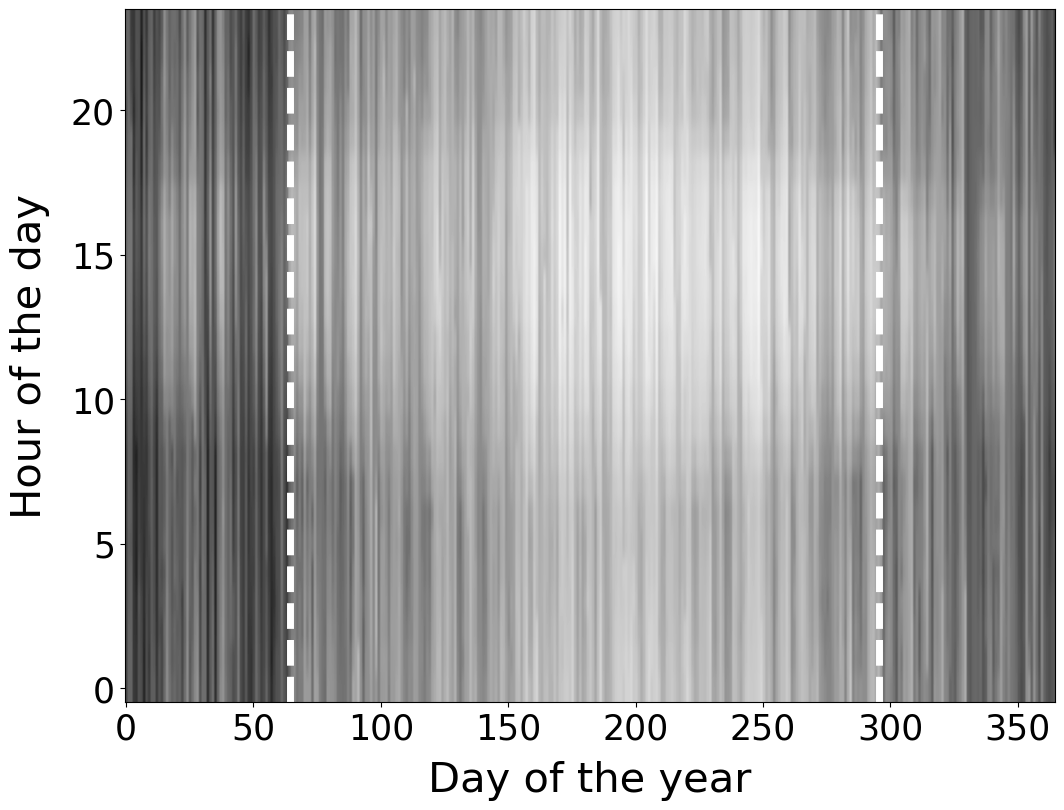

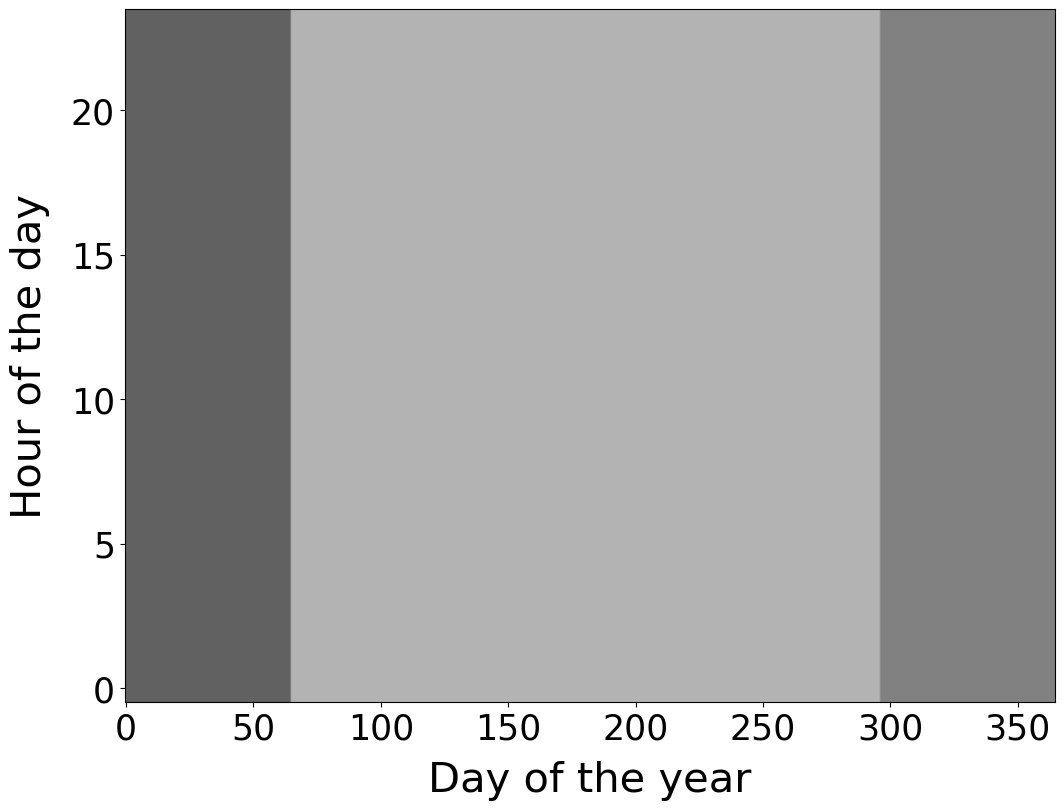

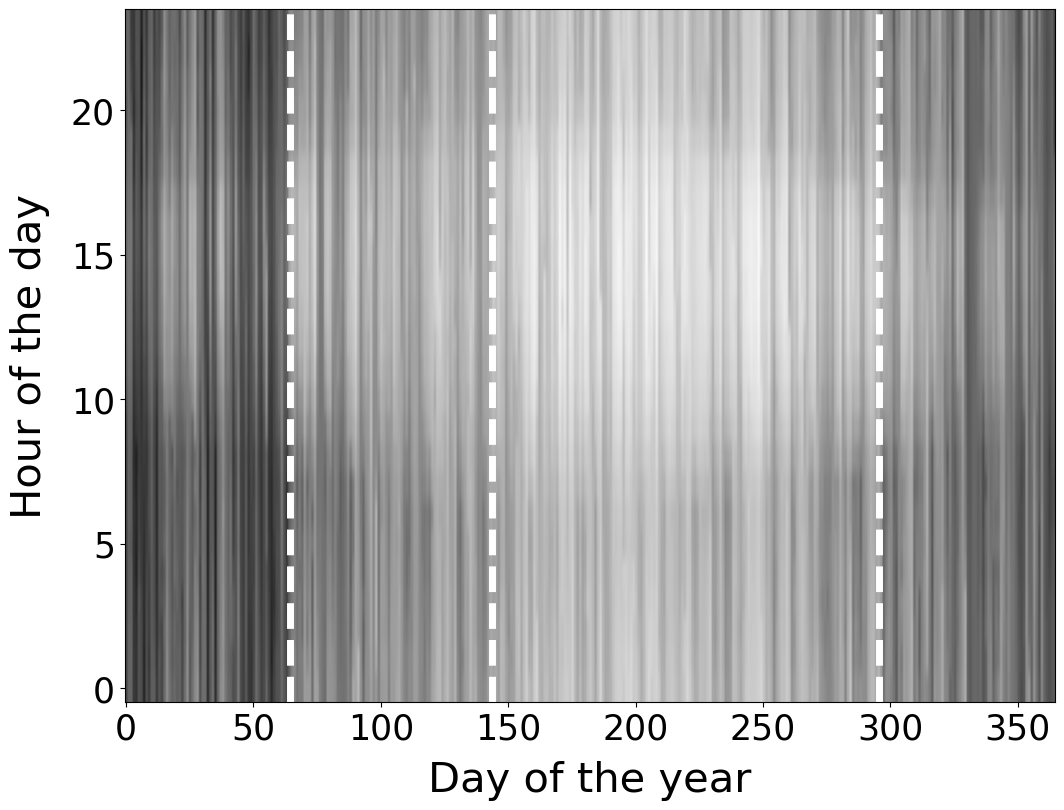

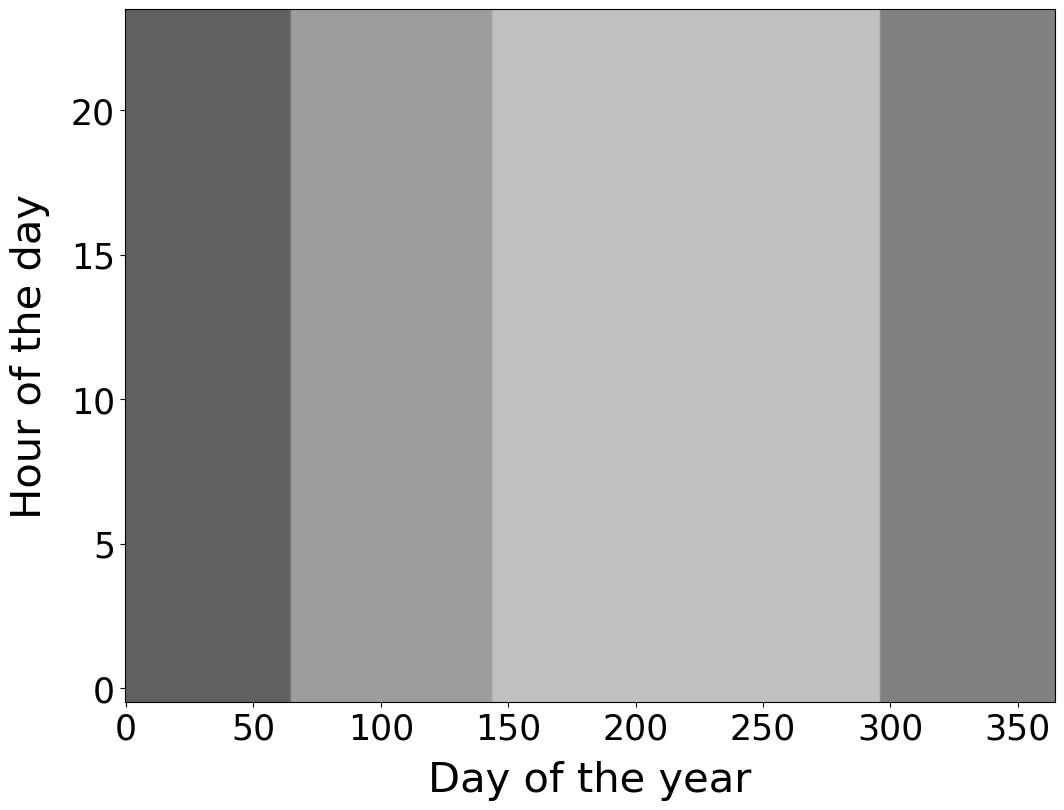

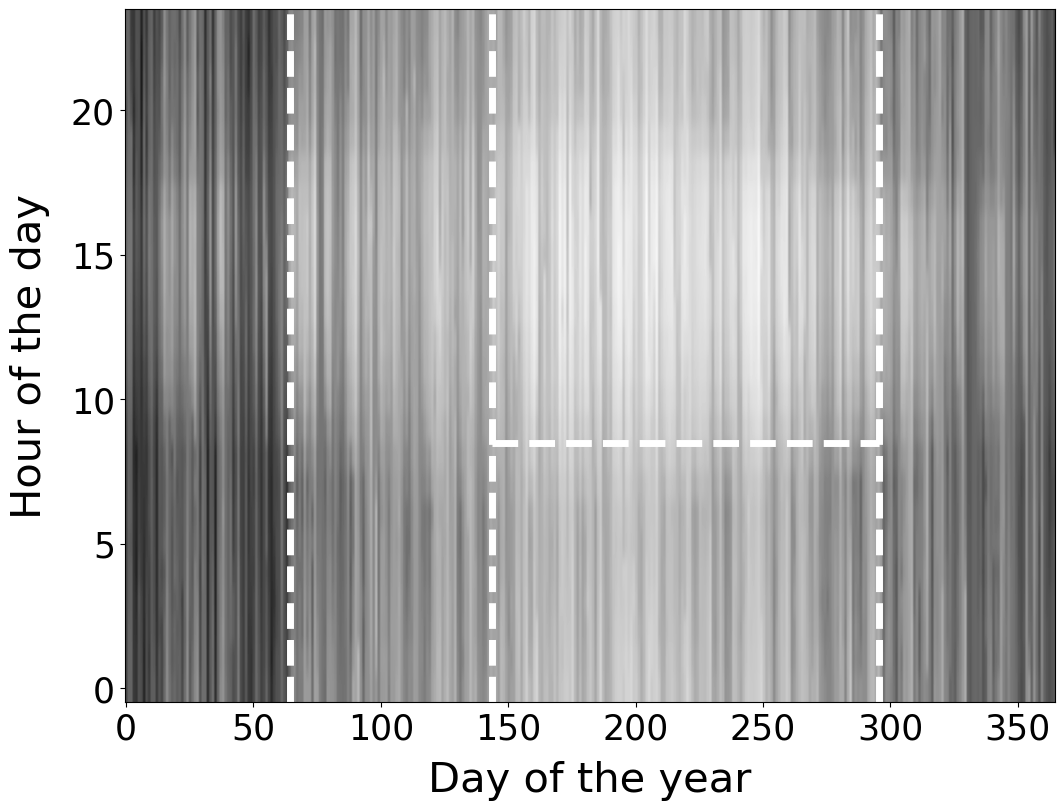

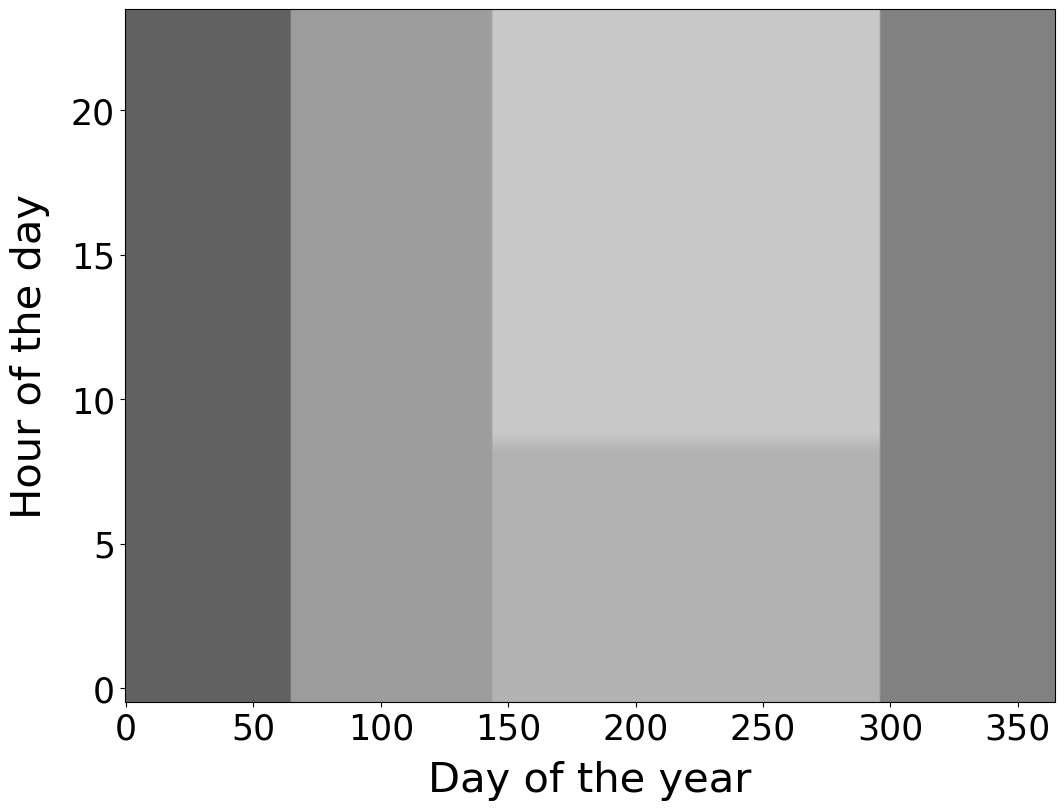

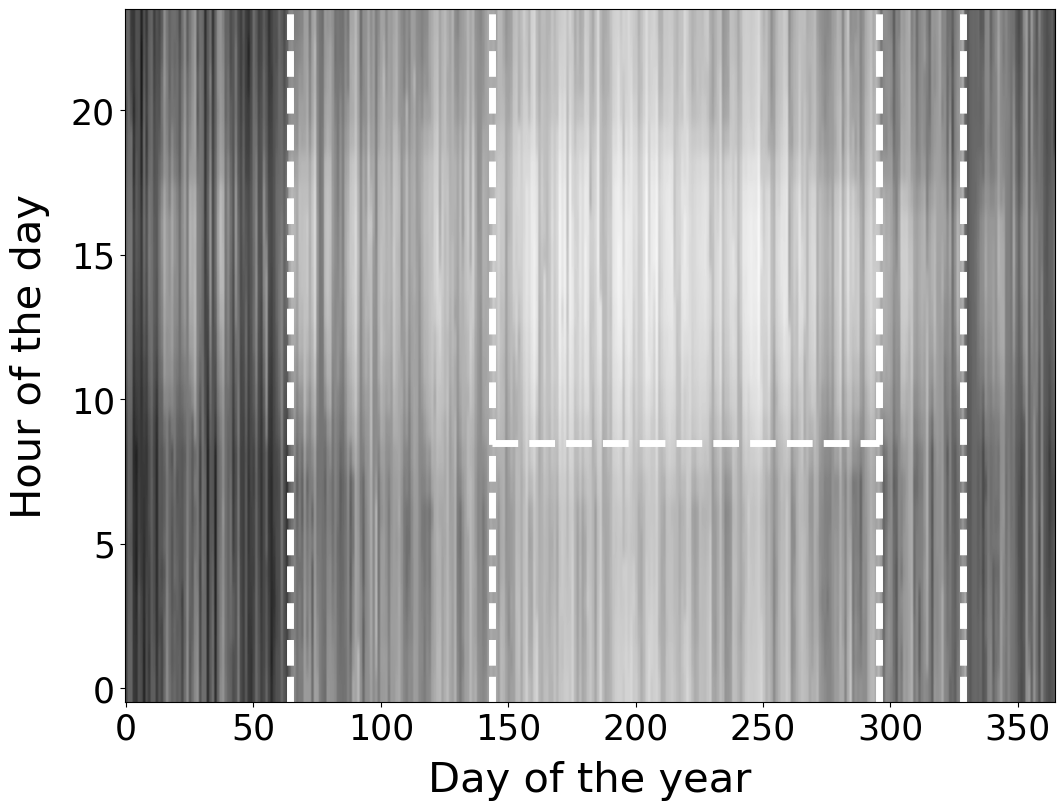

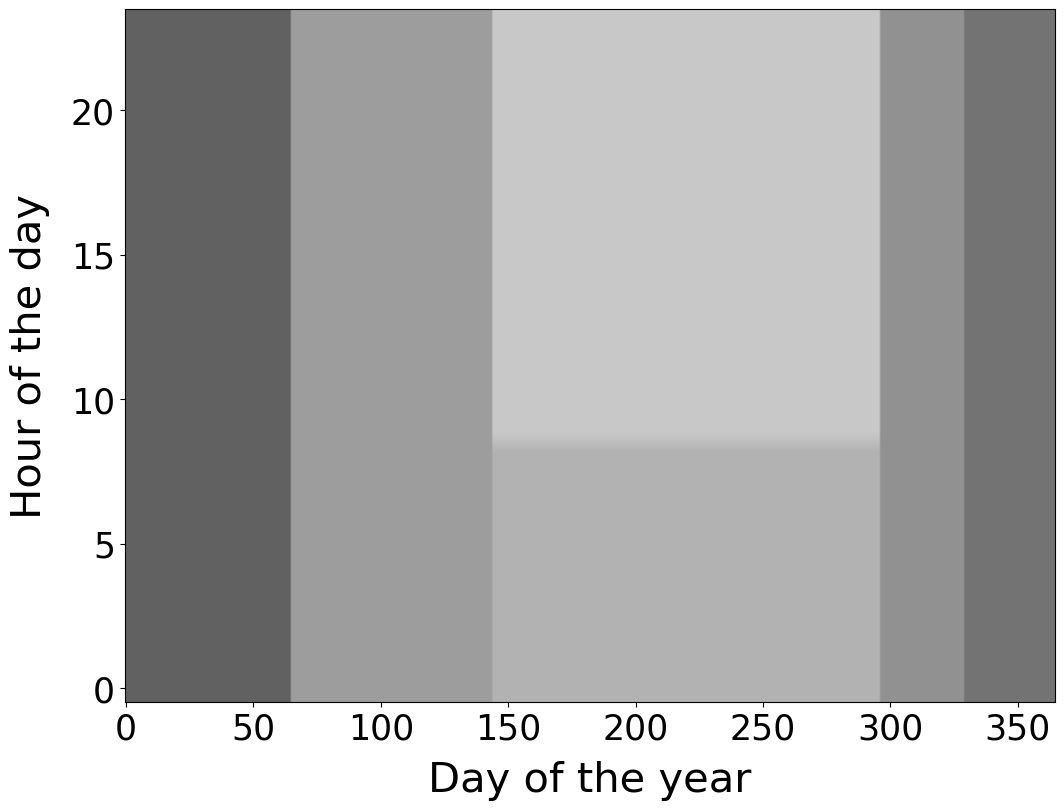

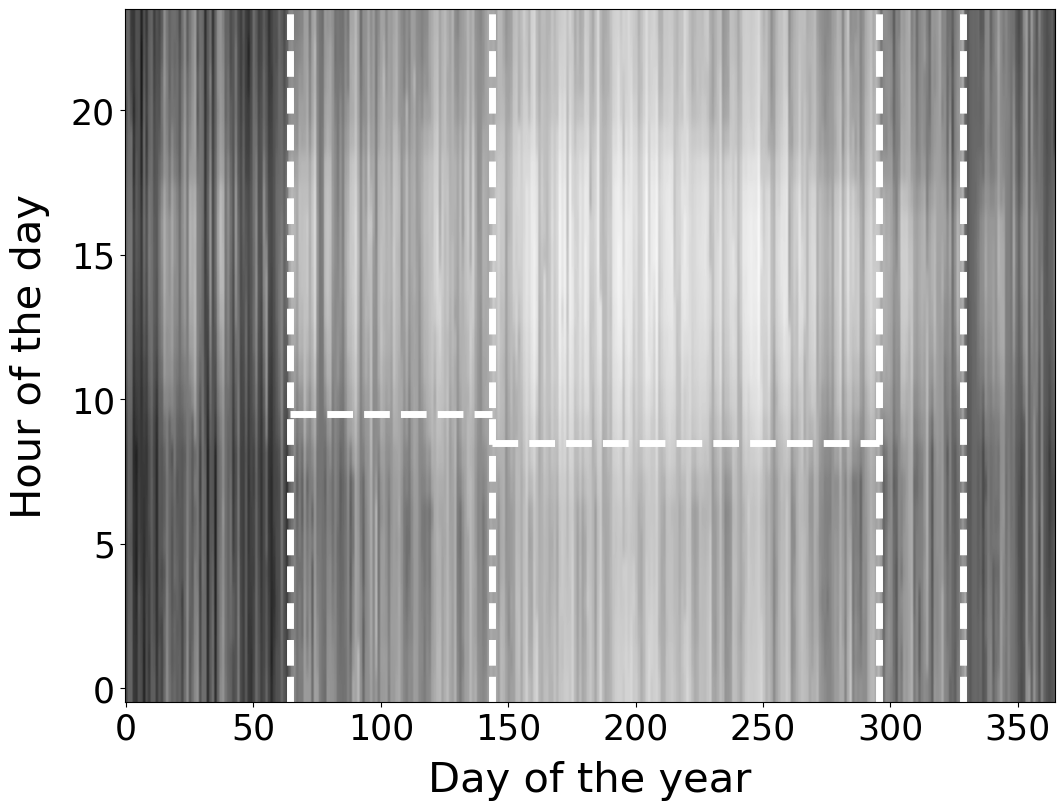

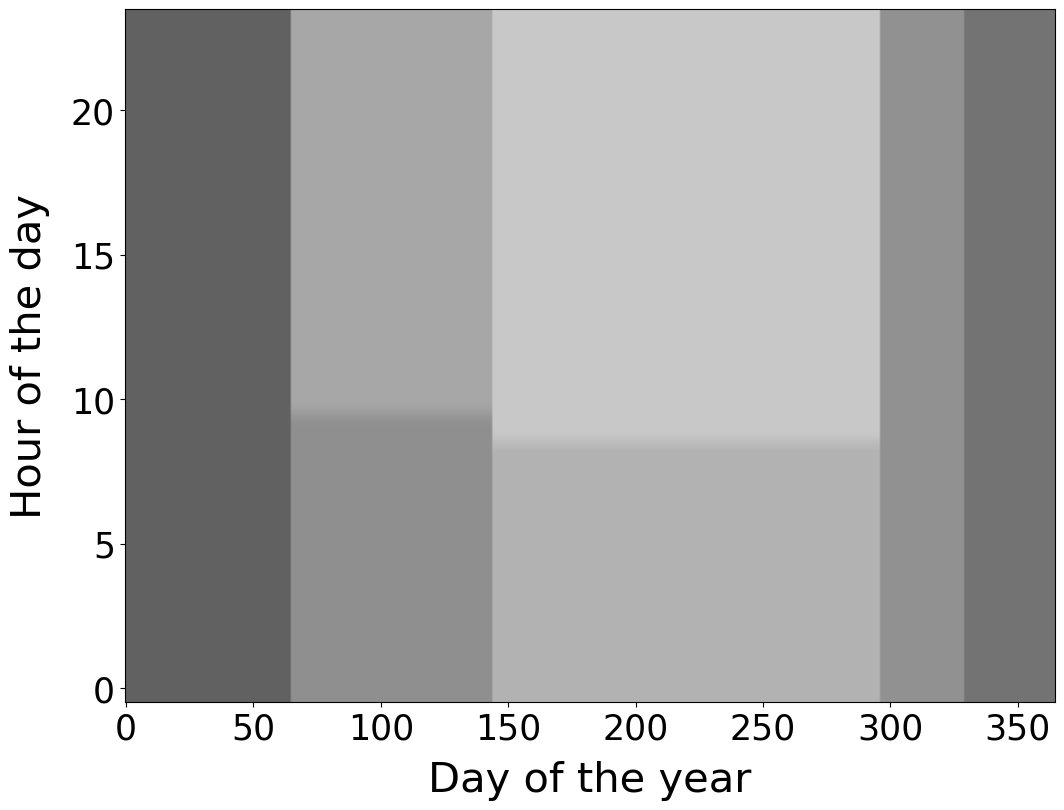

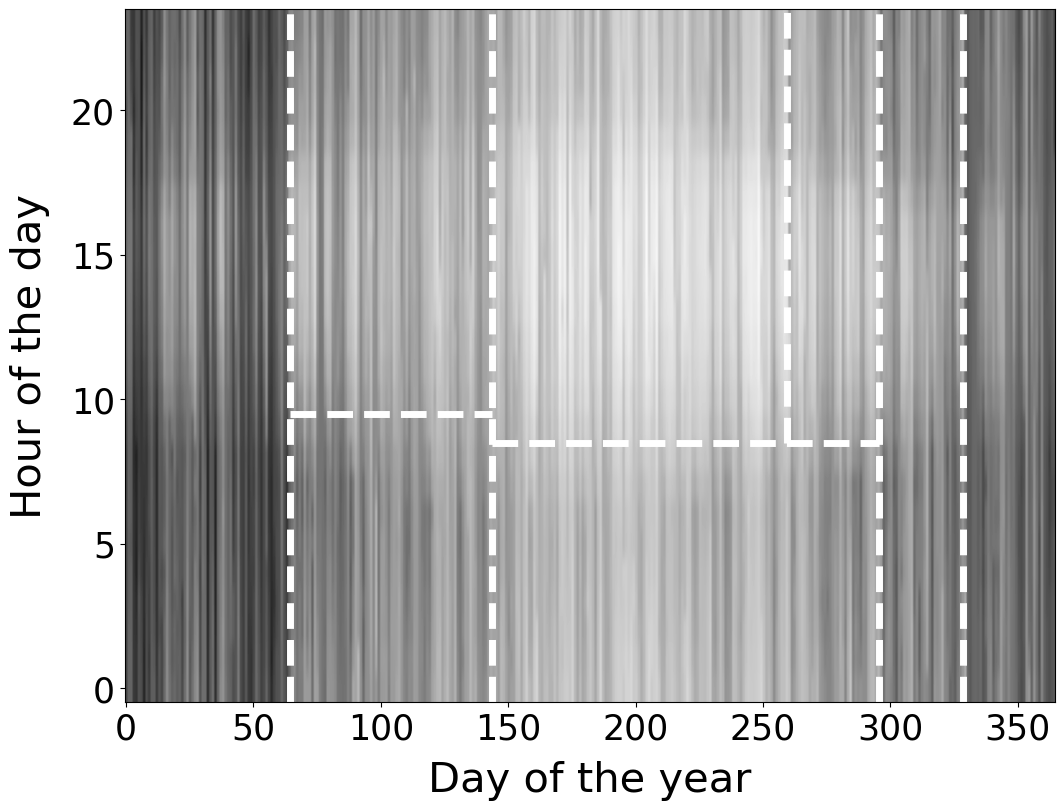

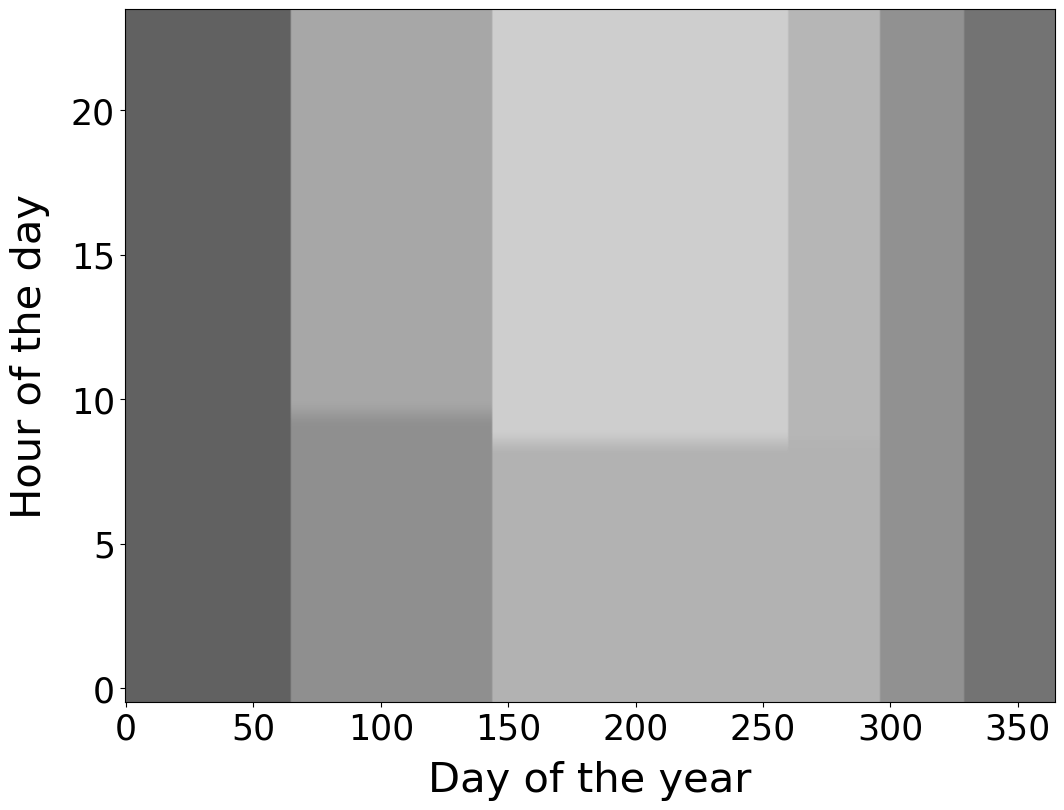

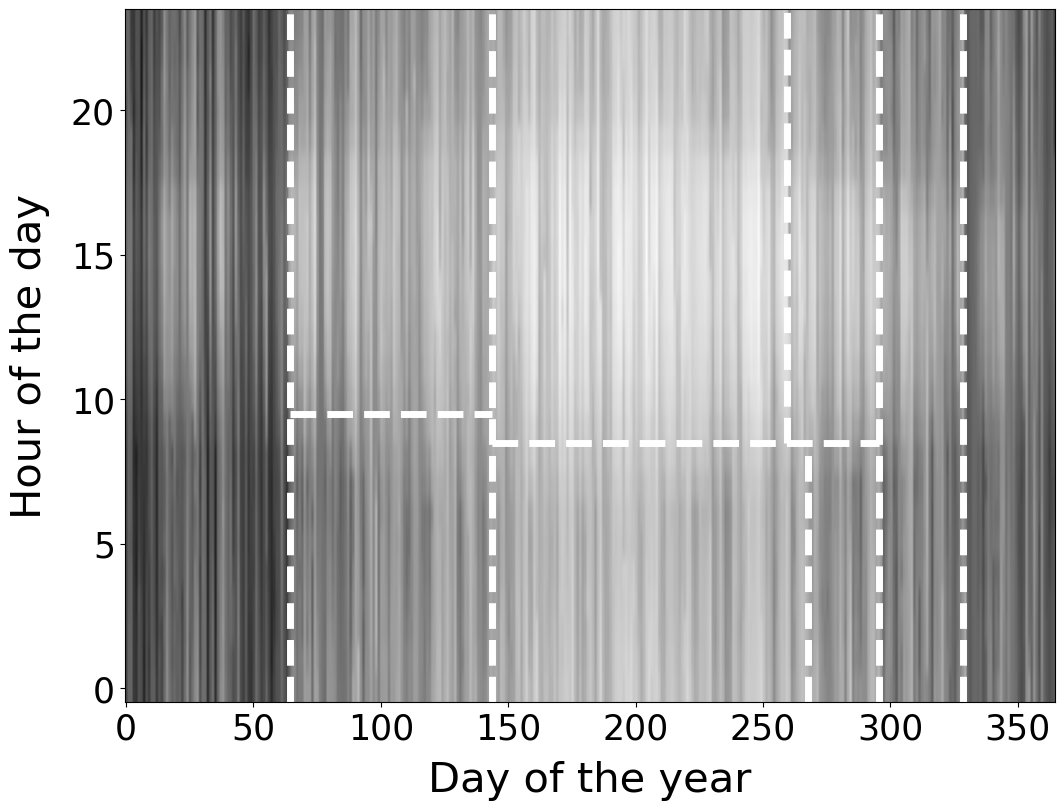

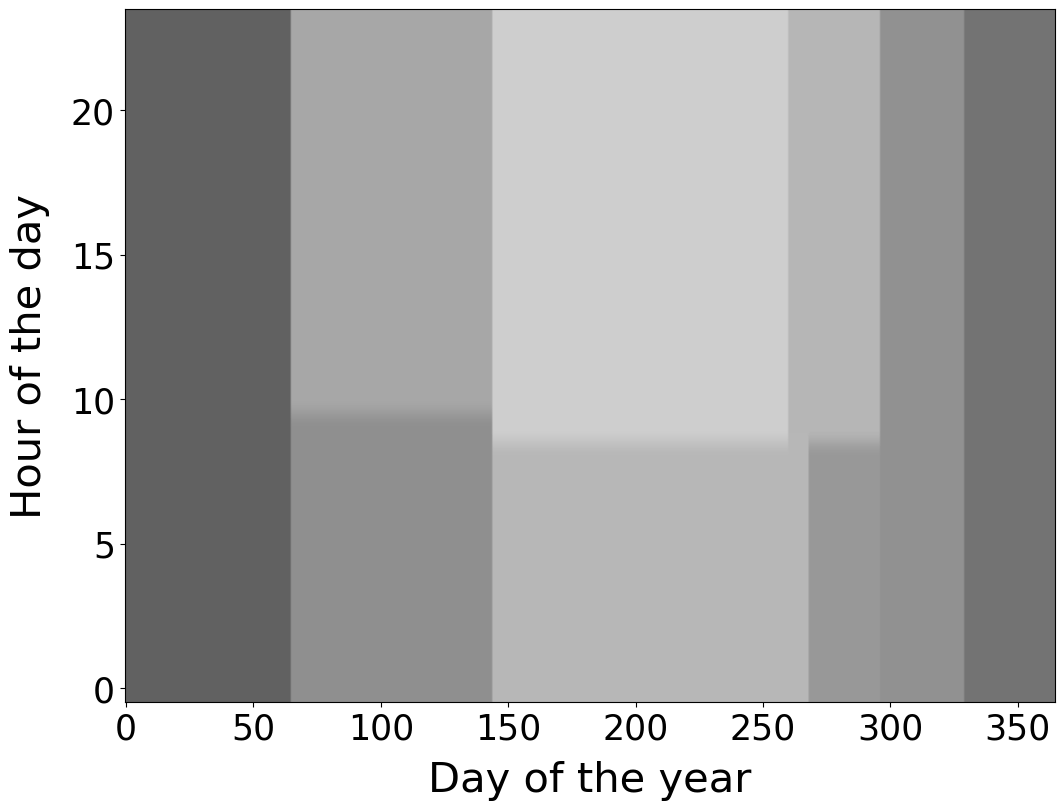

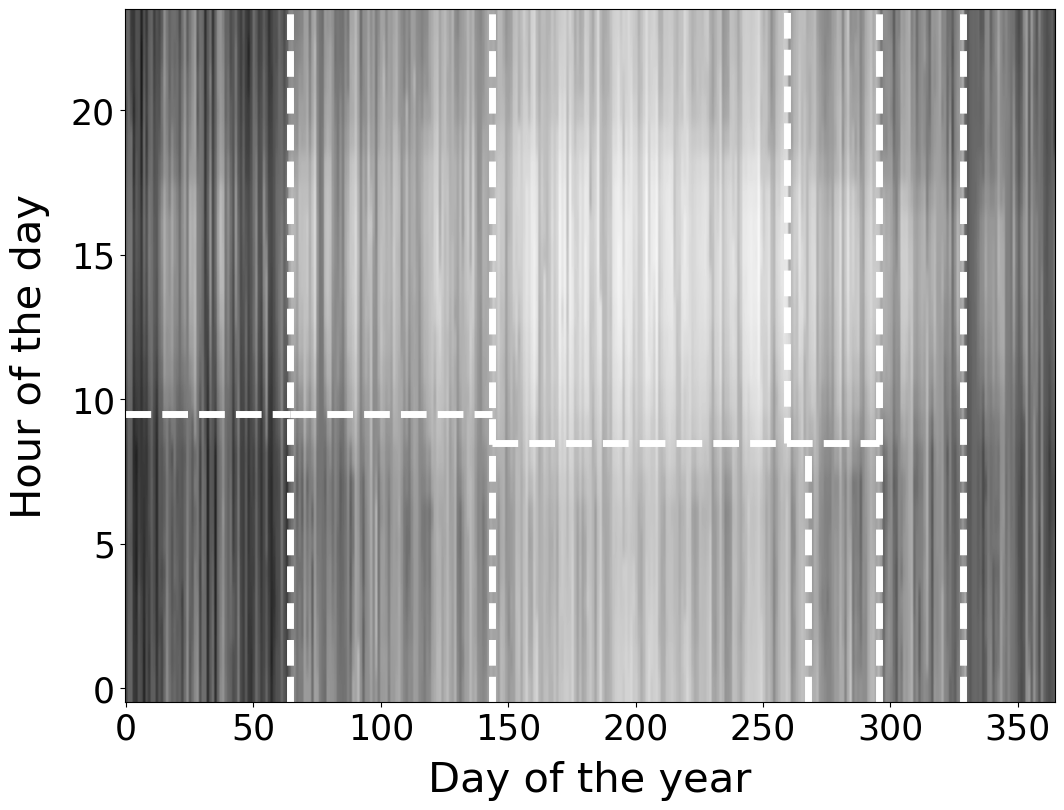

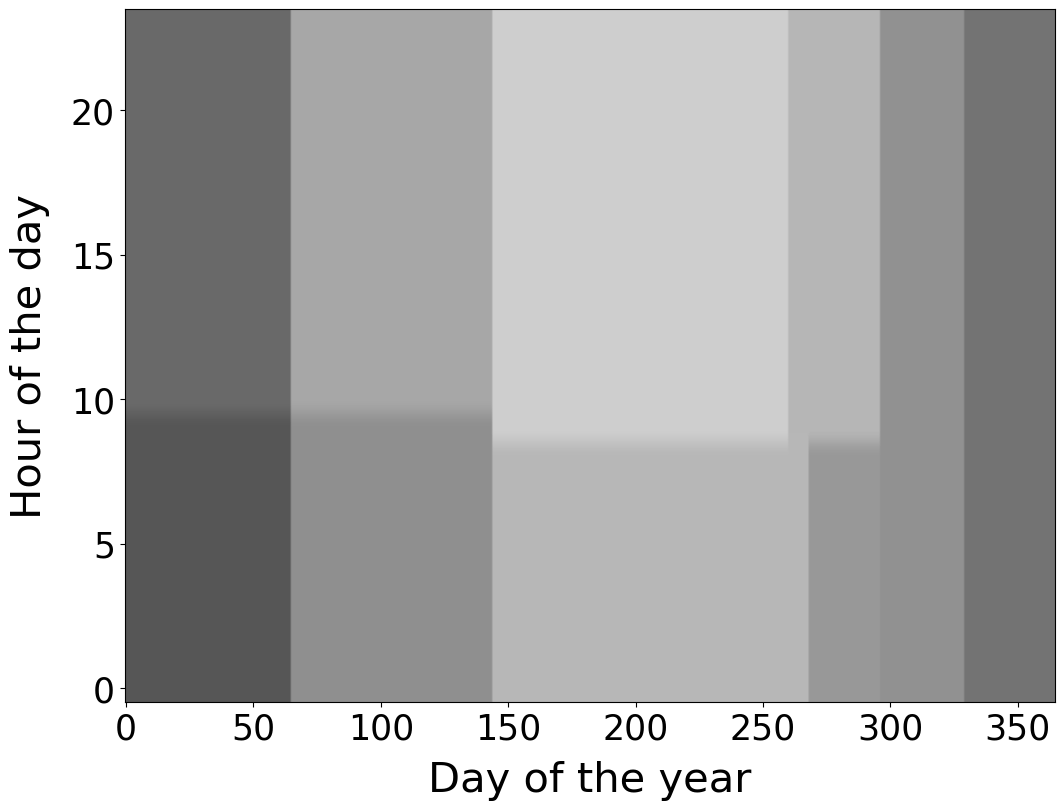

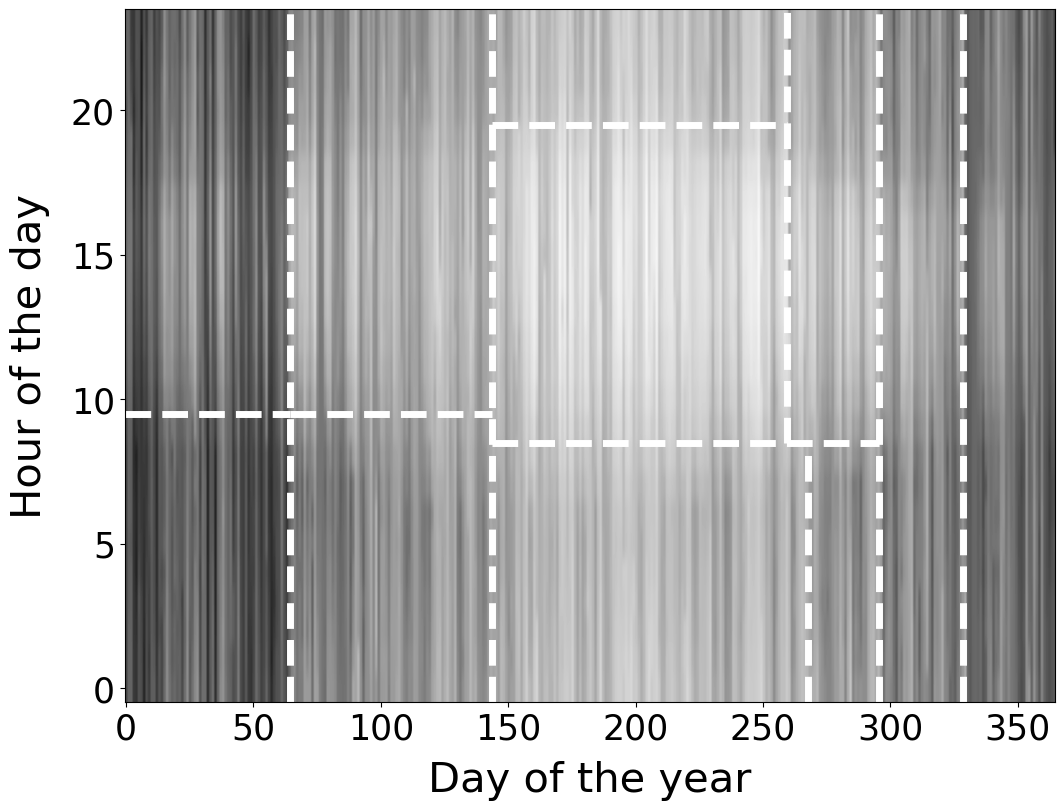

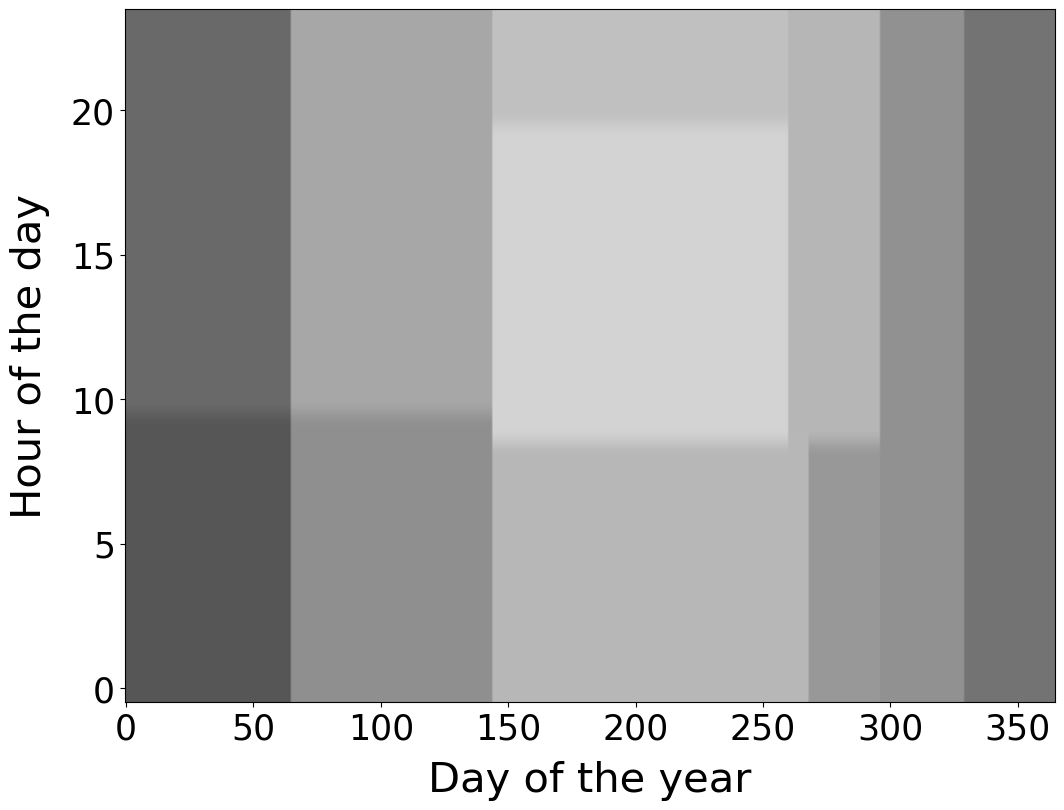

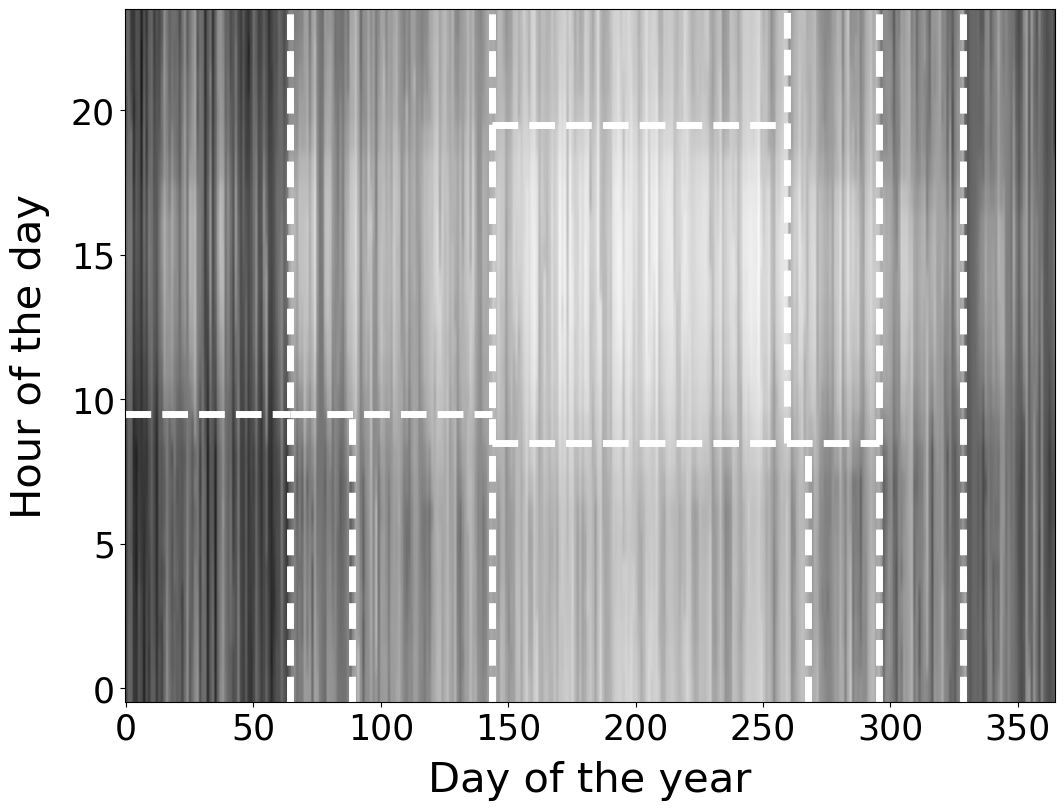

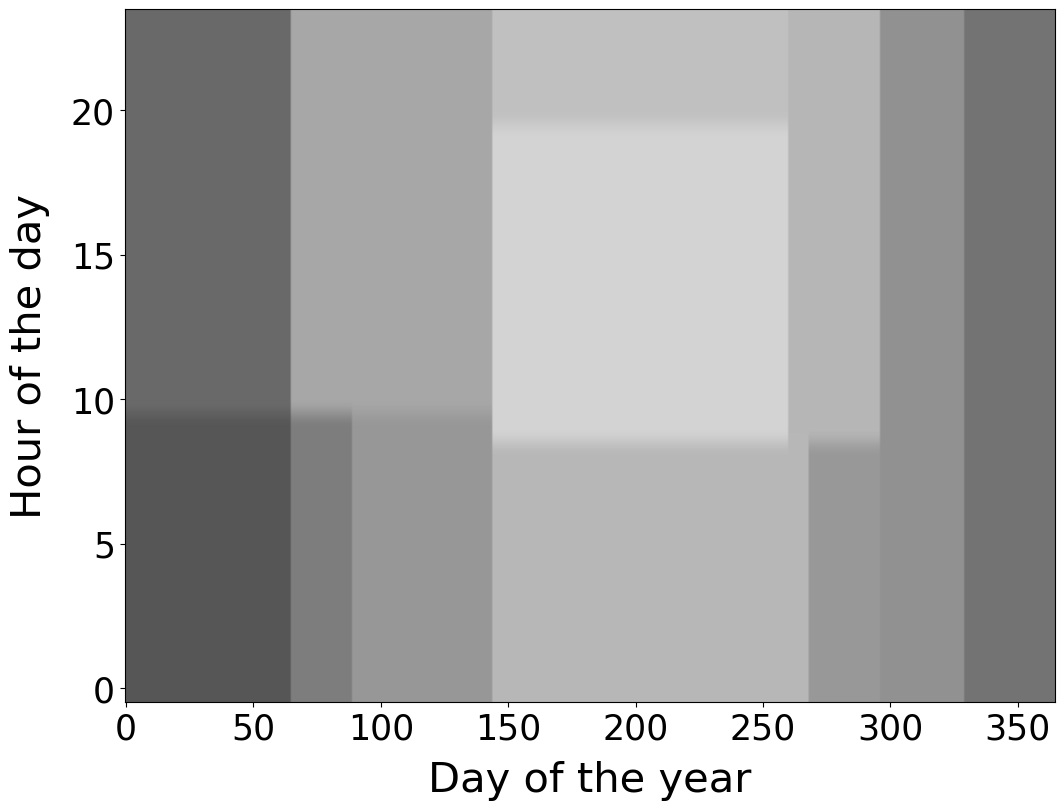

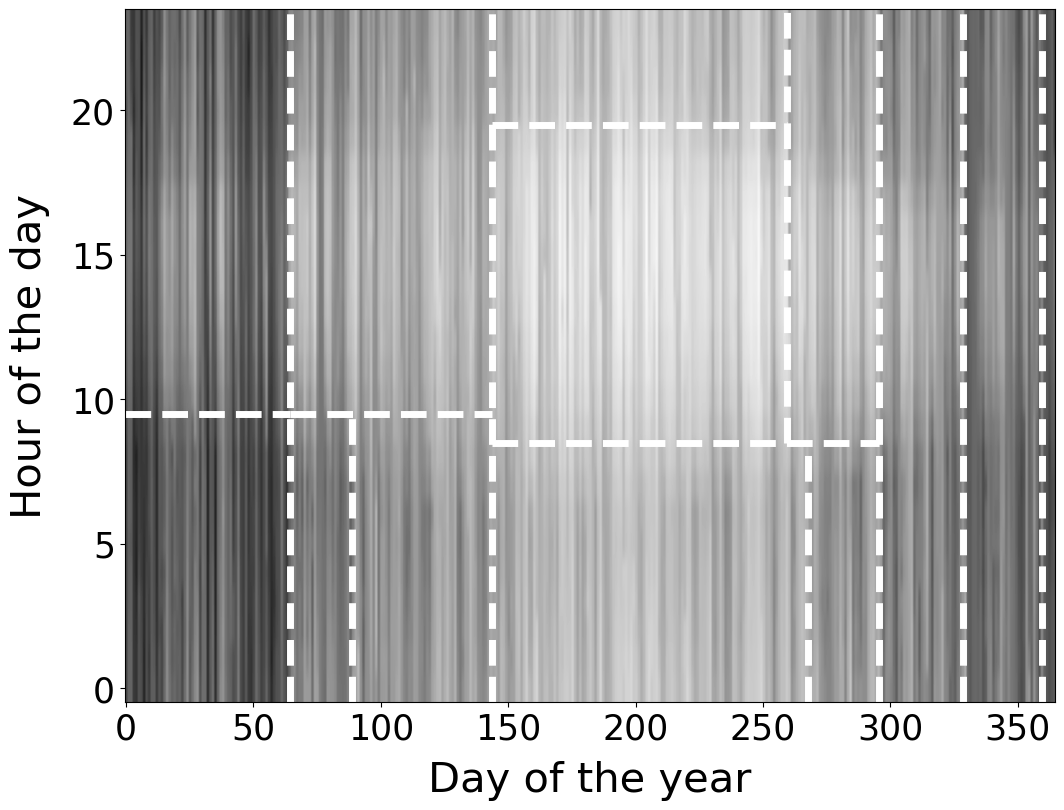

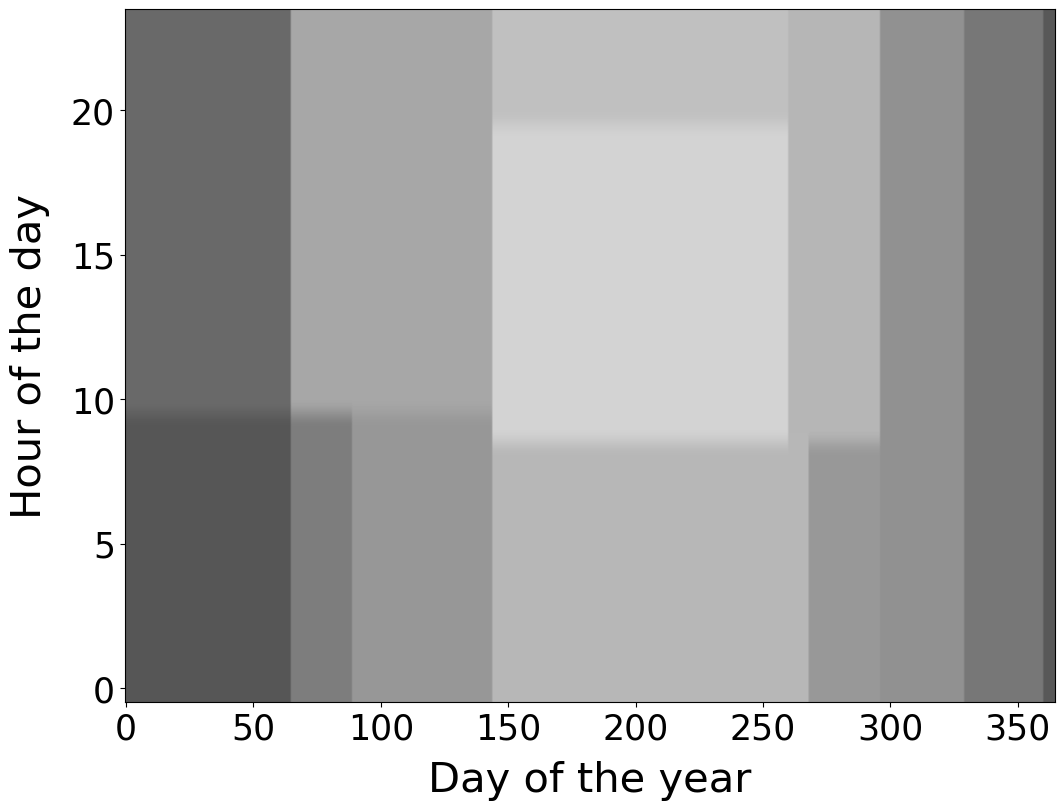

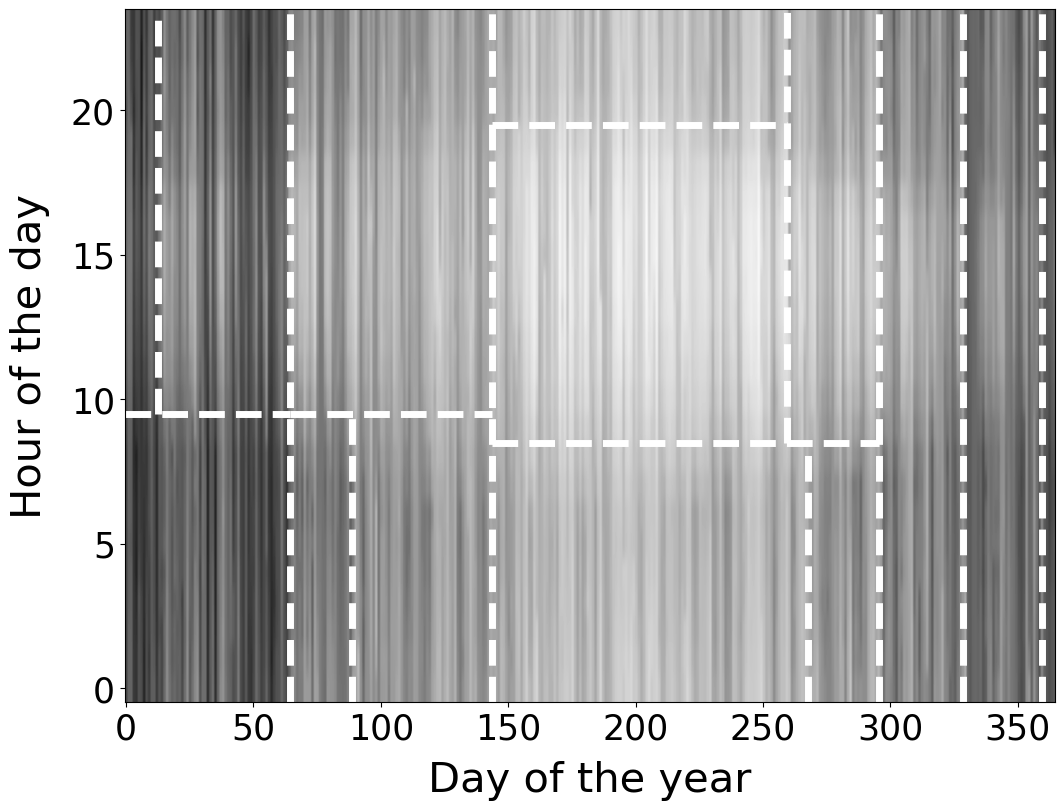

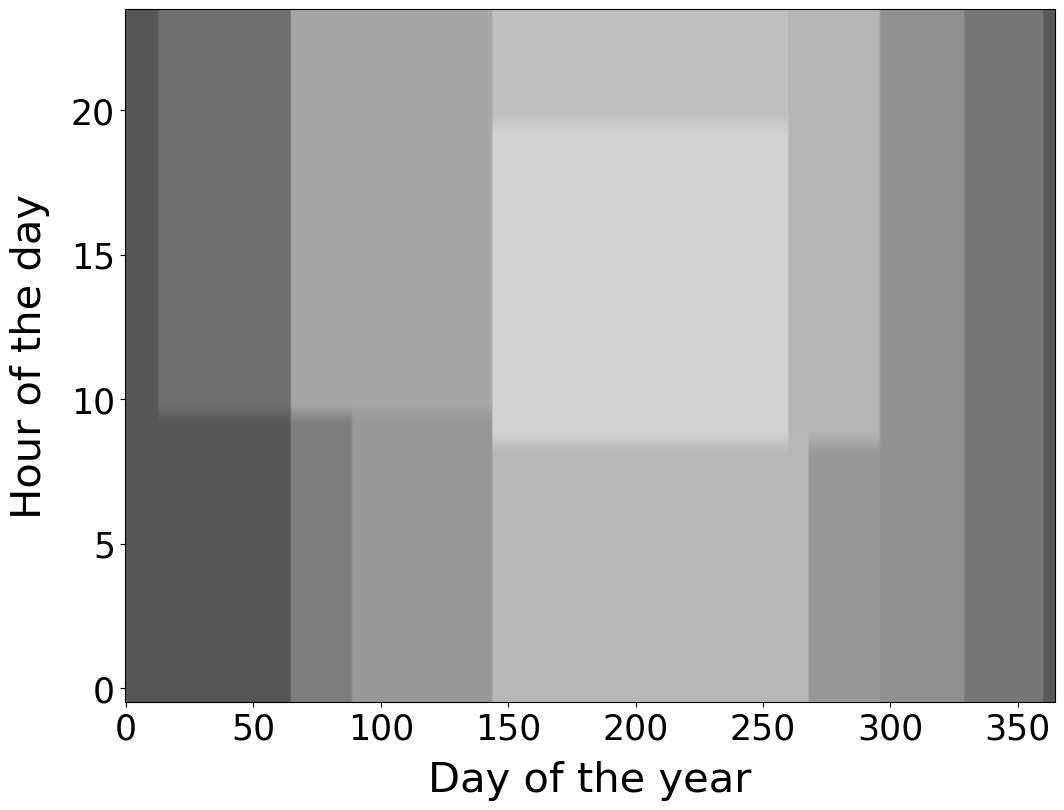

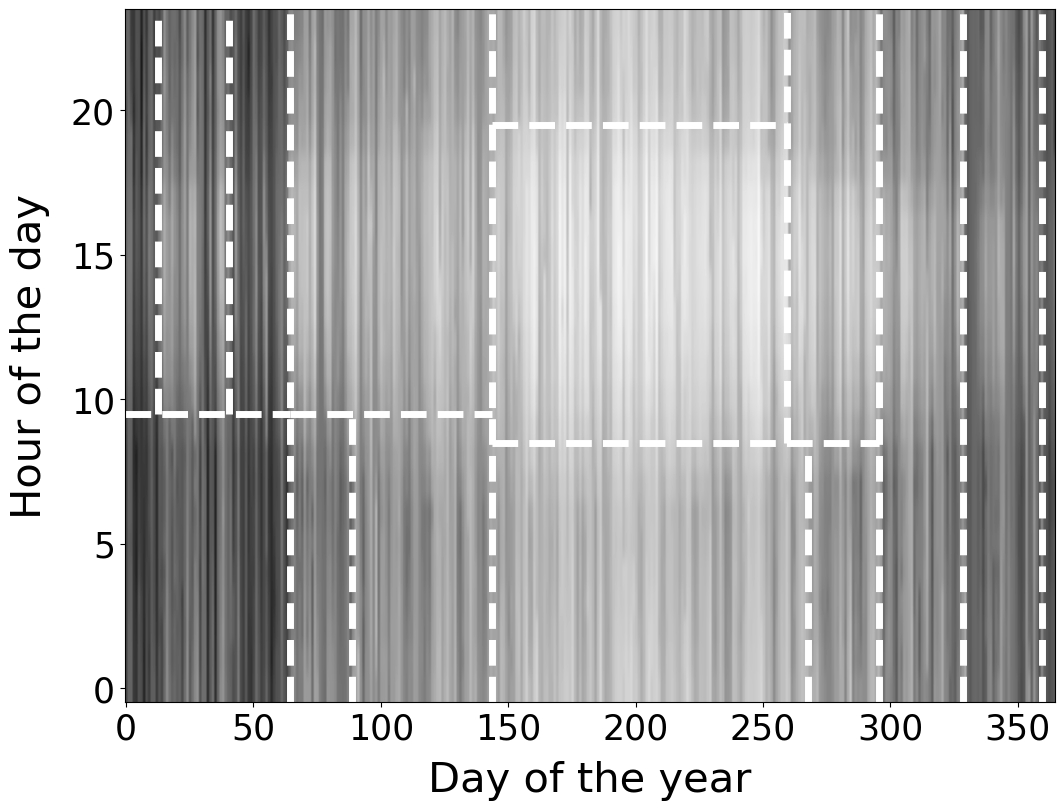

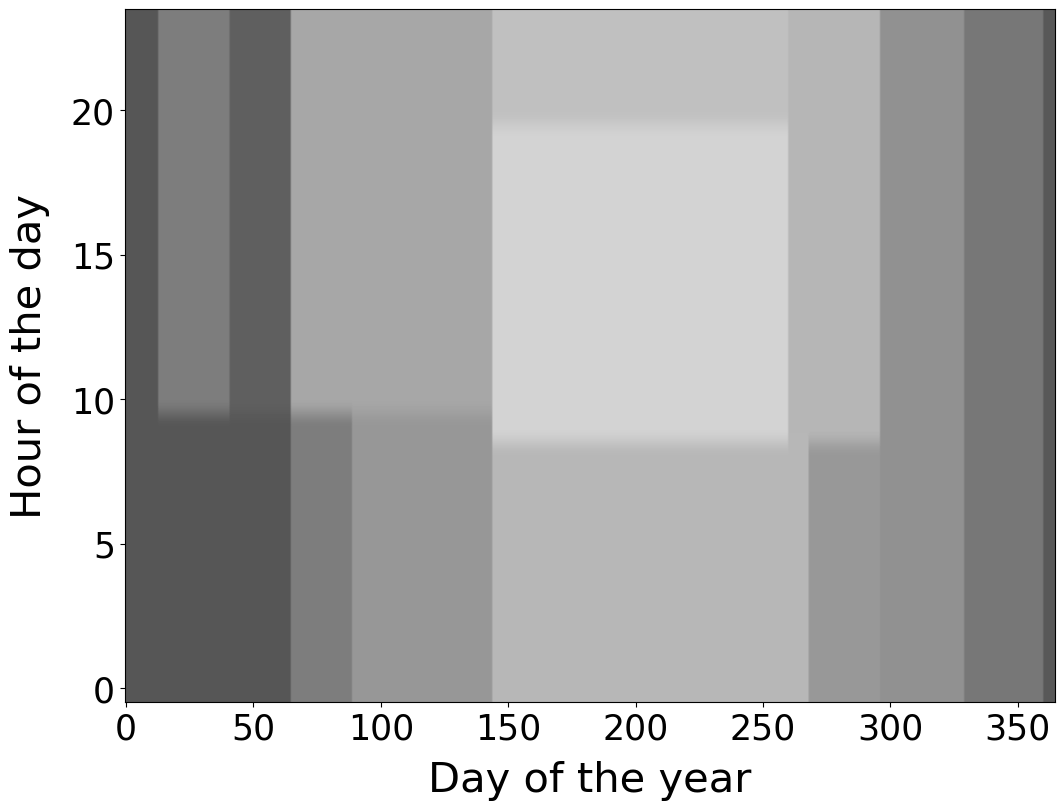

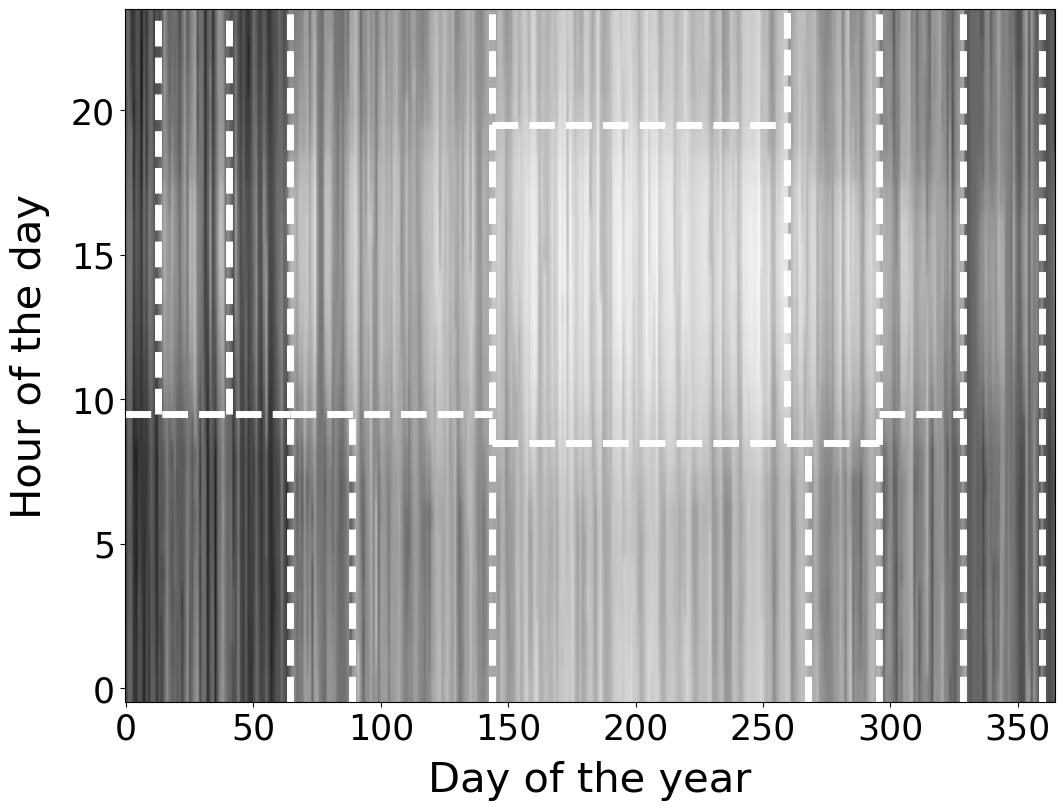

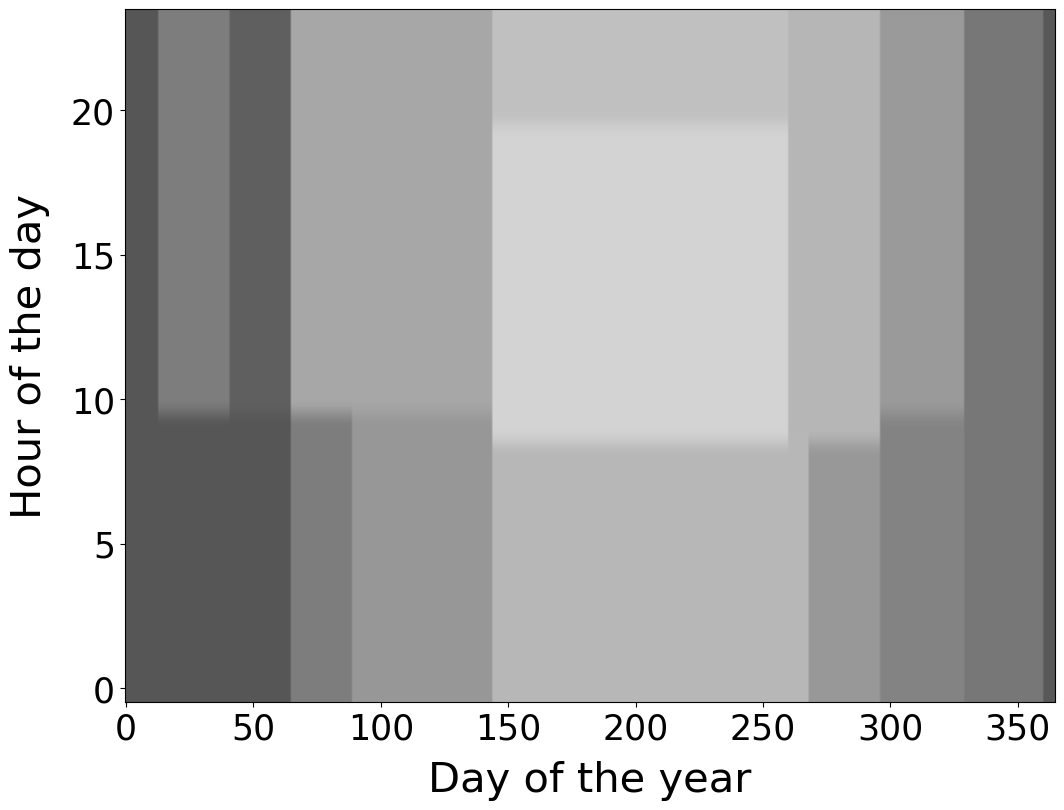

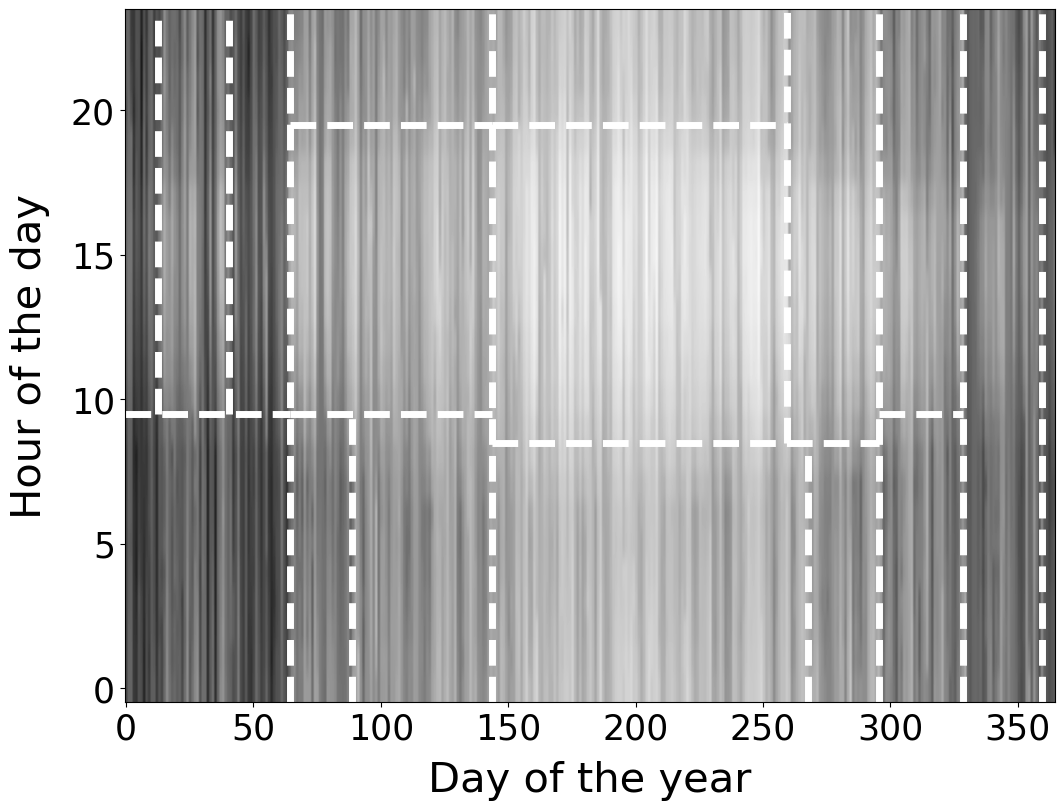

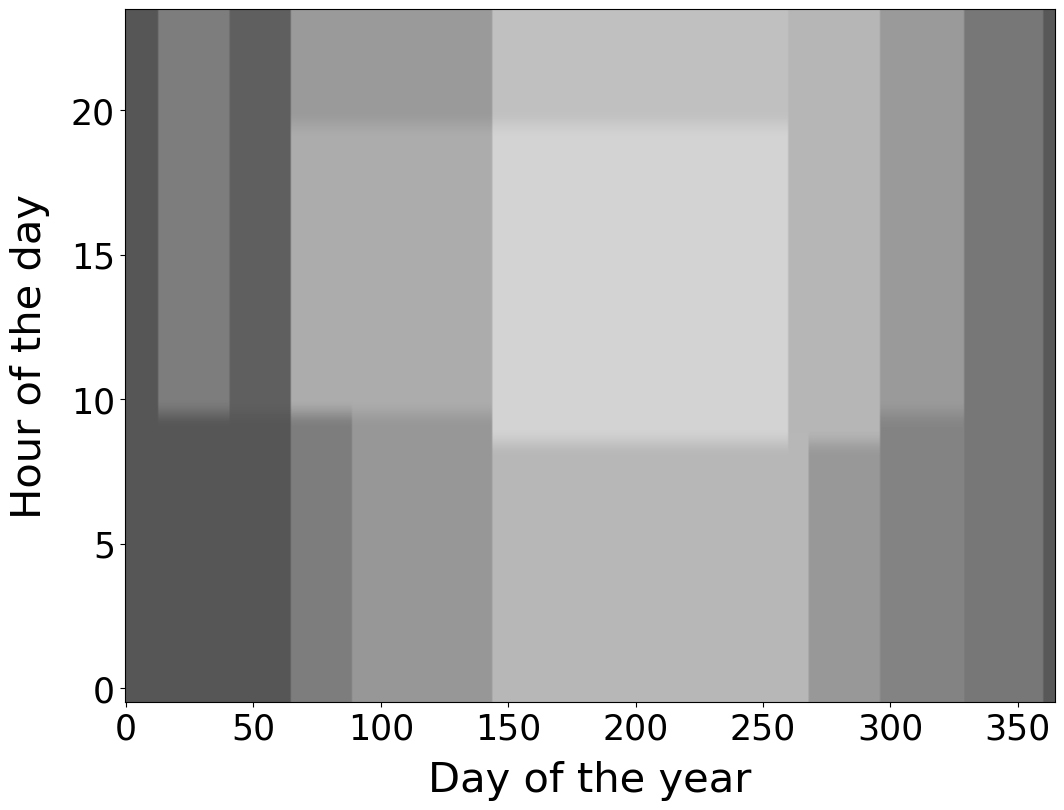

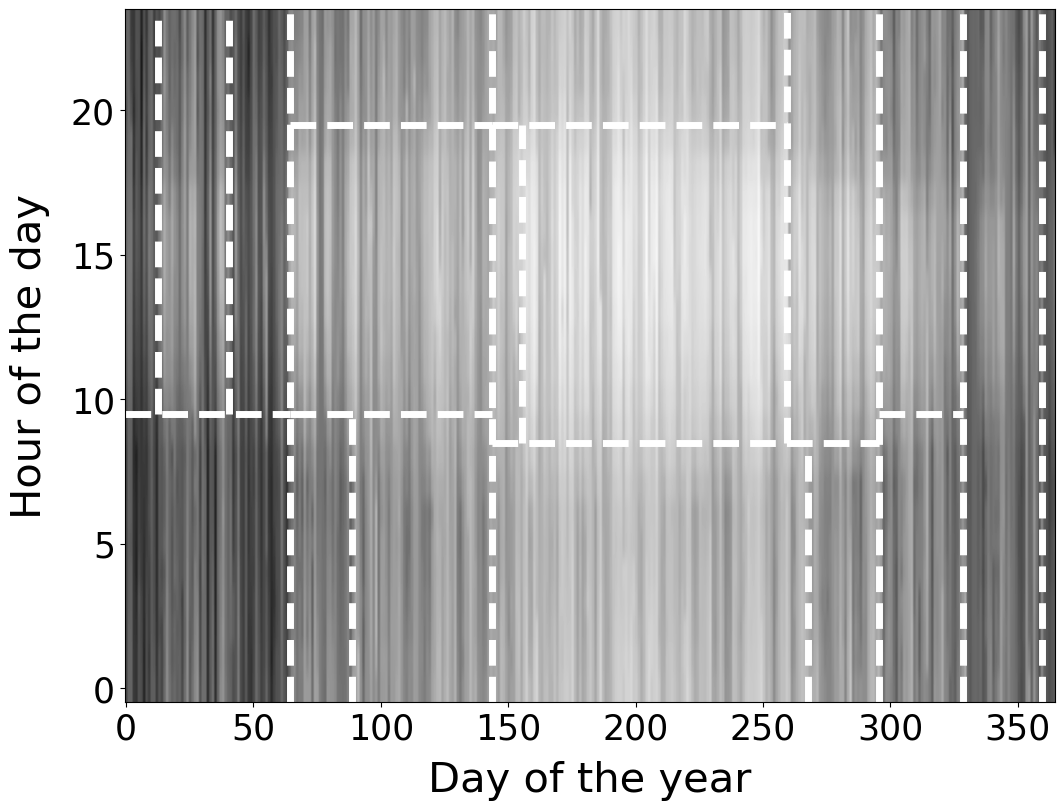

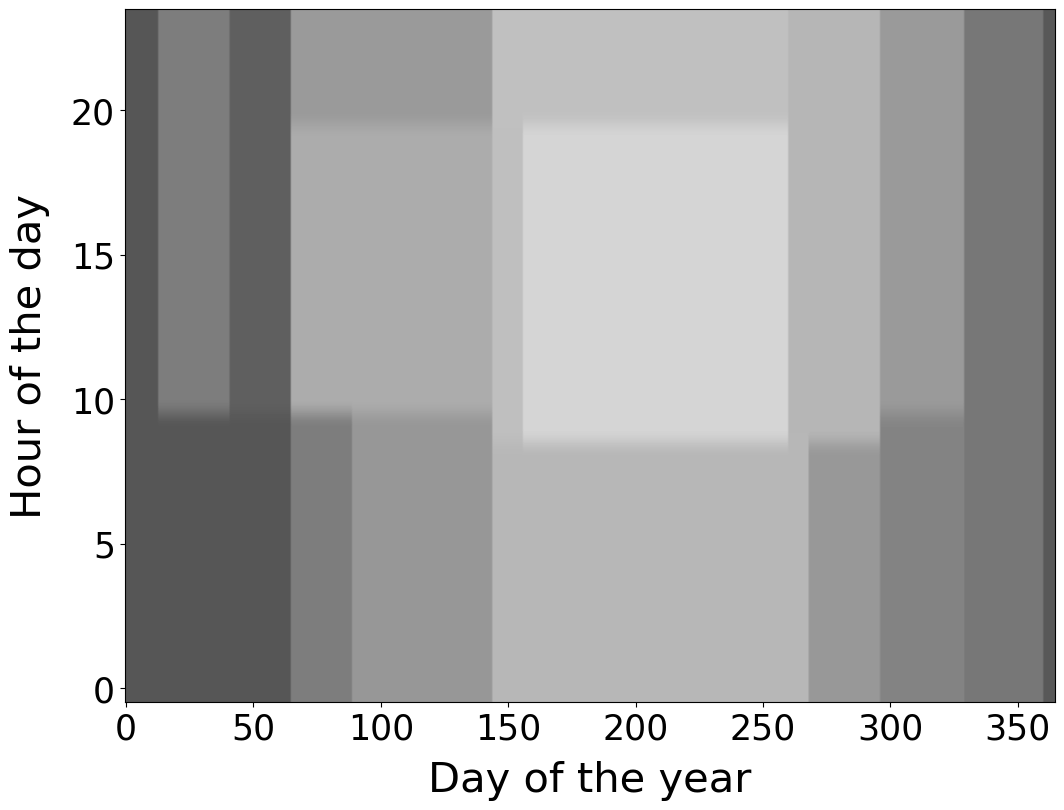

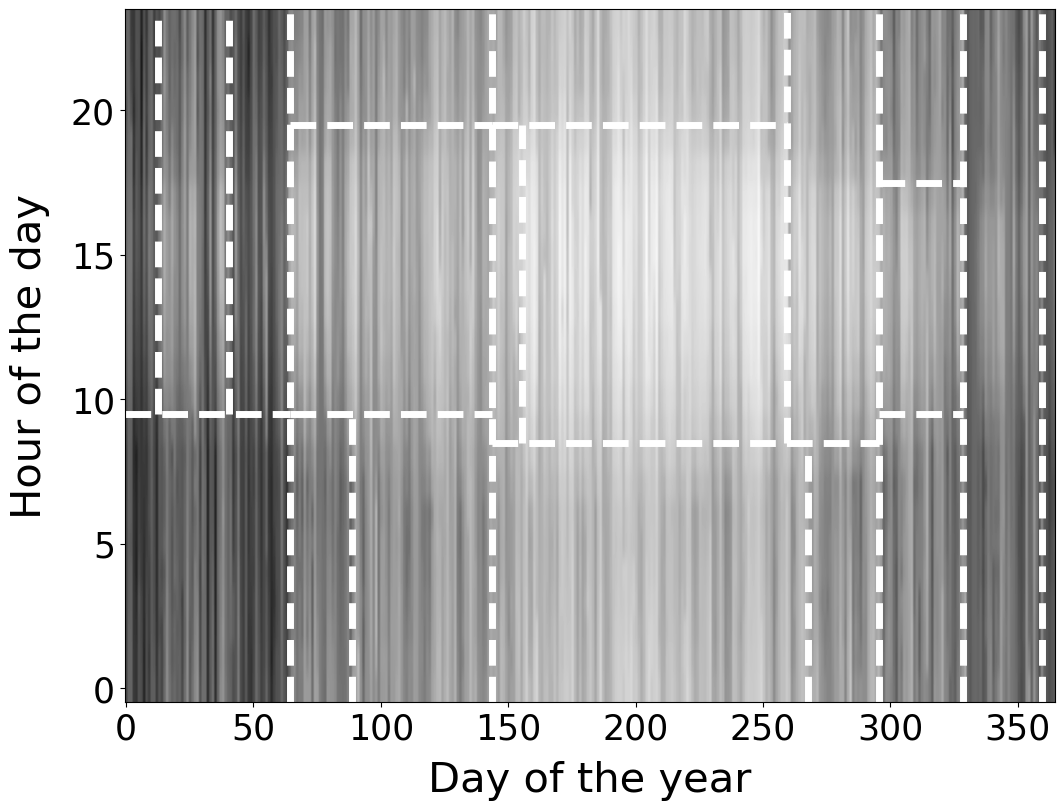

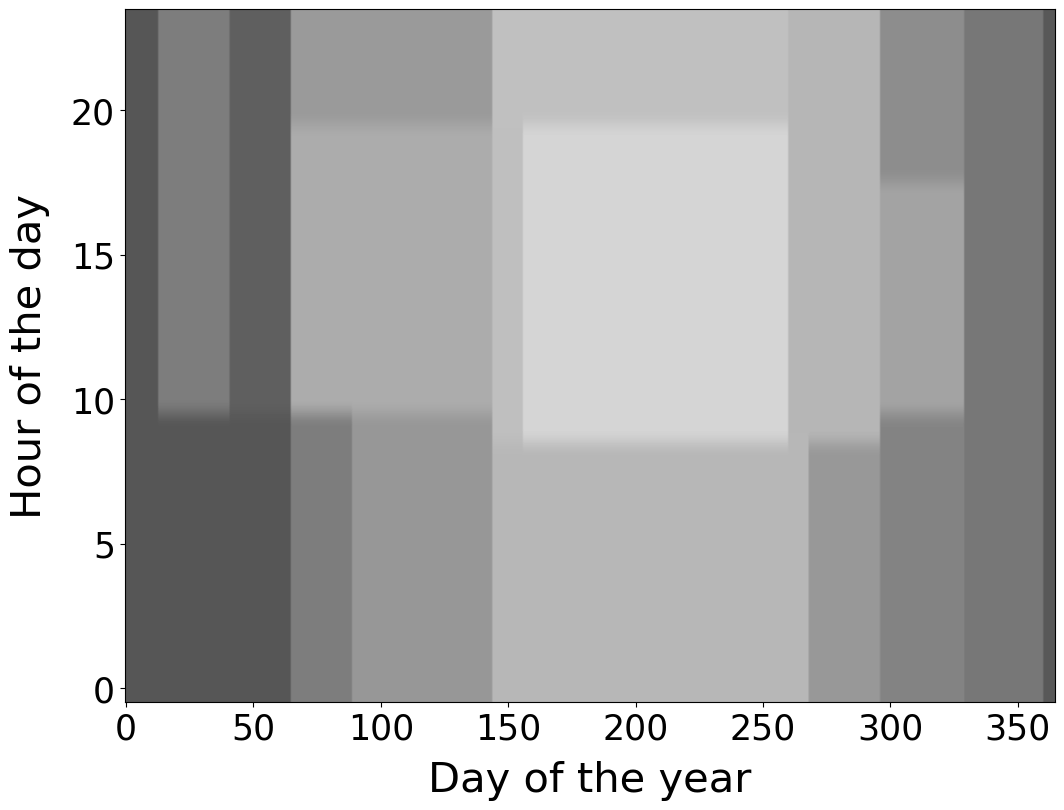

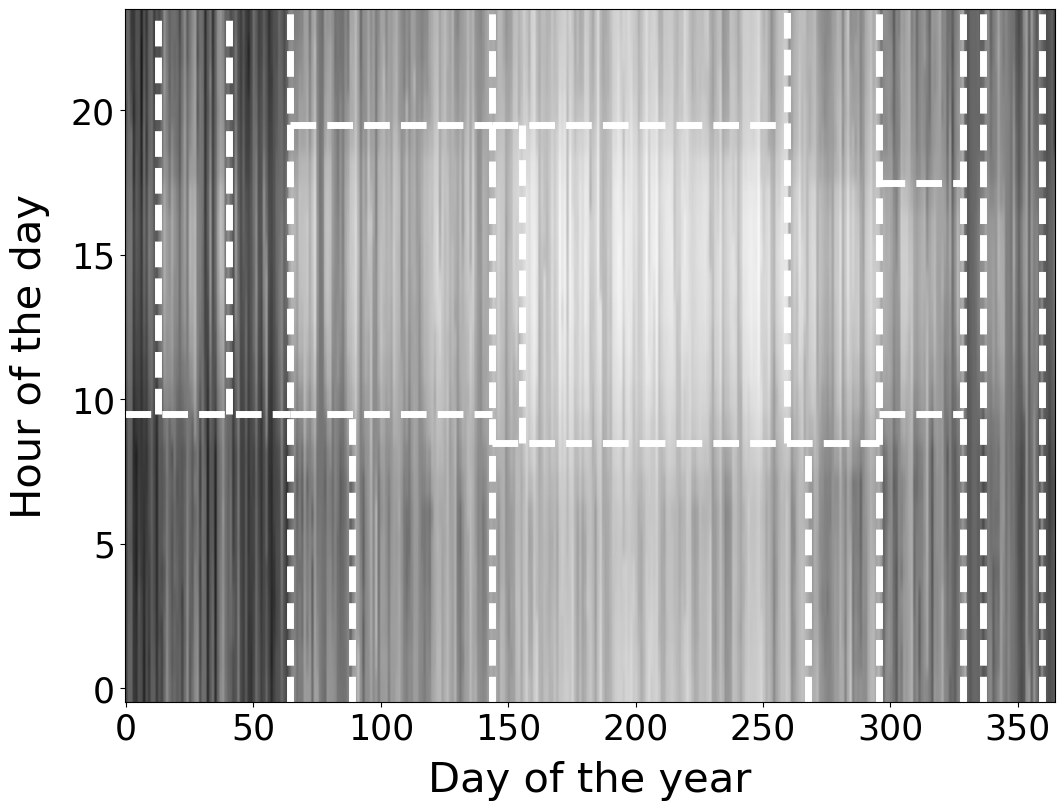

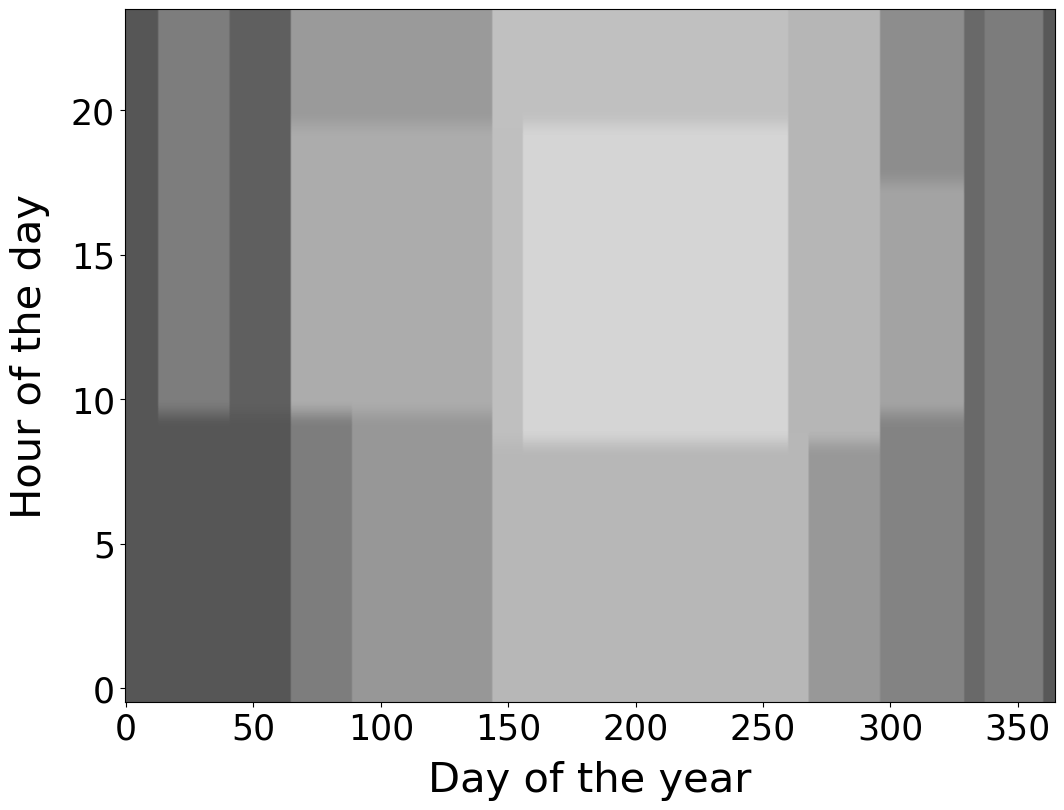

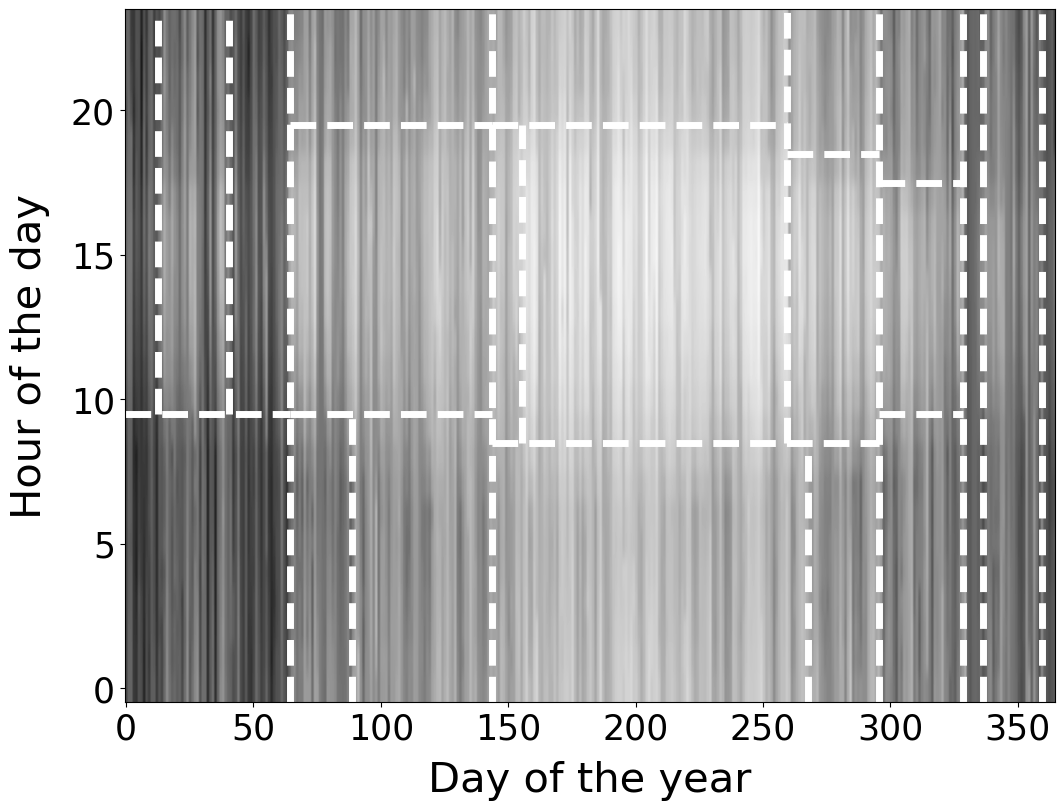

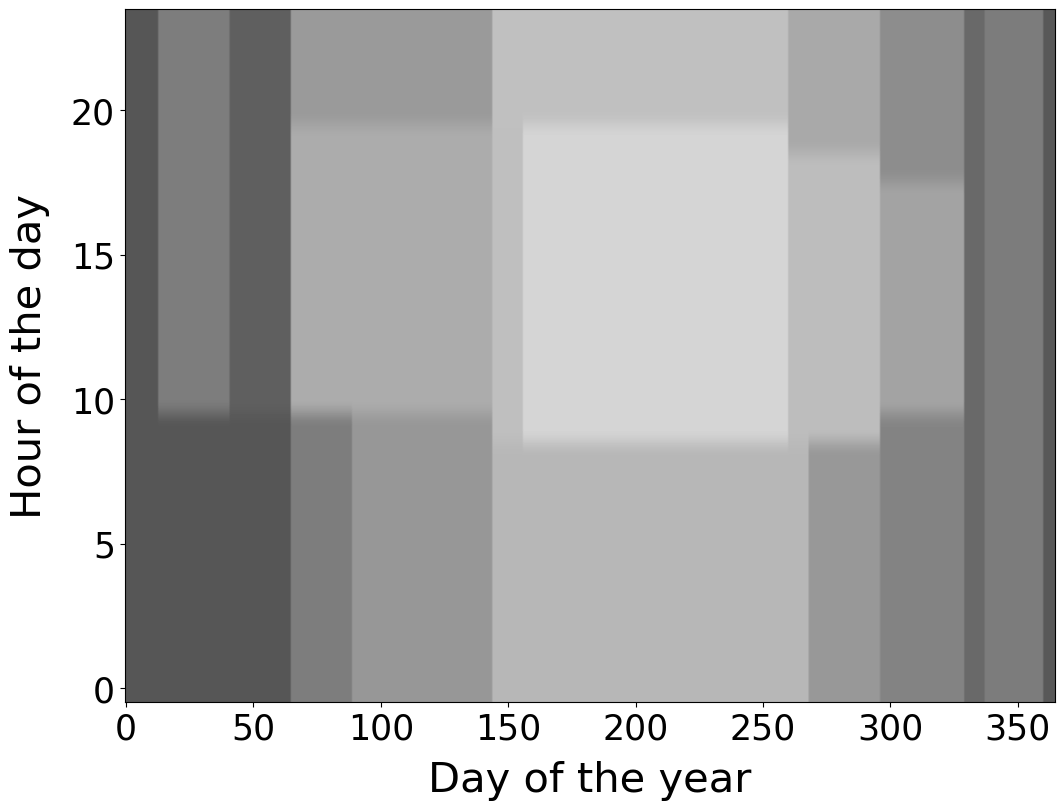

In [680]:
plot_lines = []
first_region = {
  "day_lims": [1,n_days],
  "hour_lims": [0,n_hours-1]
}
regions = [first_region]

if verbose:
    print("First region")
    print("Estimate",np.mean(temperature_2015))
            
n_splits = 20
verbose = True
find_split_verbose = False
markerlist = ['o','d','s','^','>']
msize=8
medgewidth=1
MSE_2015_splits = np.zeros(n_splits+1)
MSE_2016_splits = np.zeros(n_splits+1)

str_save = str(0)
[MSE_2015,MSE_2016] = tree_estimate(regions,str_save,verbose)

MSE_2015_splits[0] = MSE_2015 #np.sum( (temperature_2015 - np.mean(temperature_2015))**2 )/n_2015
MSE_2016_splits[0] = MSE_2016 #np.sum( (temperature_2016 - np.mean(temperature_2015))**2 )/n_2016

plot_splits = [3]


for ind_splits in range(n_splits):
    
    if verbose:
        print("Split",ind_splits+1)
    
    if plot_split_options:
        plt.figure(figsize=(10,5))
        plt.xticks(fontsize=font_size_ticks) 
        plt.yticks(fontsize=font_size_ticks)
    
    split_region_ind = -1
    split_feature = ""
    split_thresh = -1
    best_err_decrease = 0
    for ind_r,r in enumerate(regions):
        
        inds_region_2015 = inds_region(r)
        temp_region_2015 = temperature_2015[inds_region_2015]
        day_region_2015 = day_2015[inds_region_2015]
        hour_region_2015 = hour_2015[inds_region_2015]
        err_region = np.sum((temp_region_2015-np.mean(temp_region_2015))**2)
        possible_thresholds_day = np.arange(r["day_lims"][0],r["day_lims"][1]+1)
        err_day = find_split(day_region_2015,temp_region_2015,possible_thresholds_day,find_split_verbose)
        best_err_day_ind = np.argmin(err_day)
        best_err_day = err_day[best_err_day_ind]
        possible_thresholds_hour = np.arange(r["hour_lims"][0],r["hour_lims"][1]+1)
        err_hour = find_split(hour_region_2015,temp_region_2015,possible_thresholds_hour,find_split_verbose)
        best_err_hour_ind = np.argmin(err_hour)
        best_err_hour = err_hour[best_err_hour_ind]
        if plot_split_options:
            plt.plot(possible_thresholds_day,(err_region-err_day)/n_2015,color="black",markersize=msize, 
                 marker=markerlist[ind_r], markeredgewidth=medgewidth,ls = 'None',markeredgecolor="black",
                 label="Reg. " + str(ind_r+1) + " day")
            plt.plot(possible_thresholds_hour,(err_region-err_hour)/n_2015,color="white",markersize=msize, 
                 marker=markerlist[ind_r],markeredgewidth=medgewidth, ls = 'None',markeredgecolor="black",
                 label="Reg. " + str(ind_r+1) + " hour")
        if best_err_day < best_err_hour:
            feature = "day"
            thresh = possible_thresholds_day[best_err_day_ind]
            err_decrease = err_region-best_err_day
        else:
            feature = "hour"
            thresh = possible_thresholds_hour[best_err_hour_ind]
            err_decrease = err_region-best_err_hour
        if split_region_ind == -1 or err_decrease > best_err_decrease:
            split_region_ind = ind_r
            split_feature = feature
            split_thresh = thresh
            best_err_decrease = err_decrease
    if plot_split_options:
        plt.legend(fontsize=font_size)
    
    if verbose:
            print("Region to split",regions[split_region_ind])
            print("Feature",split_feature)
            print("Threshold",split_thresh)
    
    split_region = regions[split_region_ind]
    
    if split_feature == "day":
        
        day_lims_left = [split_region["day_lims"][0],split_thresh-1]
        hour_lims_left = split_region["hour_lims"]
        day_lims_right = [split_thresh,split_region["day_lims"][1]]
        hour_lims_right = split_region["hour_lims"]
        
        plot_lines.append(["day",split_thresh,split_region["hour_lims"][0],split_region["hour_lims"][1]])
    
    else:
        
        day_lims_left = split_region["day_lims"]
        hour_lims_left = [split_region["hour_lims"][0],split_thresh-1]
        day_lims_right = split_region["day_lims"]
        hour_lims_right = [split_thresh,split_region["hour_lims"][1]]        
        
        plot_lines.append(["hour",split_thresh,split_region["day_lims"][0],split_region["day_lims"][1]])
    
    region_left = {
      "day_lims": day_lims_left,
      "hour_lims": hour_lims_left
    }
    region_right = {
      "day_lims": day_lims_right,
      "hour_lims": hour_lims_right
    }
    
    if verbose:
            print("New left region",region_left)
            est_left = np.mean(temperature_2015[inds_region(region_left)])
            print("Estimate",est_left)
            print("New right region",region_right)  
            est_right = np.mean(temperature_2015[inds_region(region_right)])
            print("Estimate",est_right)
            
    regions.pop(split_region_ind)
    regions.append(region_left)
    regions.append(region_right)
    
    str_save = str(ind_splits+1)
    plot_regions(plot_lines,str_save)
    [MSE_2015,MSE_2016] = tree_estimate(regions,str_save,verbose)
    MSE_2015_splits[ind_splits+1] = MSE_2015
    MSE_2016_splits[ind_splits+1] = MSE_2016

0 splits
RMSE 2015 11.33056837313743
RMSE 2016 11.21570199125796
1 splits
RMSE 2015 0.0
RMSE 2016 0.0
2 splits
RMSE 2015 0.0
RMSE 2016 0.0
3 splits
RMSE 2015 0.0
RMSE 2016 0.0
4 splits
RMSE 2015 0.0
RMSE 2016 0.0
5 splits
RMSE 2015 0.0
RMSE 2016 0.0
6 splits
RMSE 2015 0.0
RMSE 2016 0.0
7 splits
RMSE 2015 0.0
RMSE 2016 0.0
8 splits
RMSE 2015 0.0
RMSE 2016 0.0
9 splits
RMSE 2015 0.0
RMSE 2016 0.0
10 splits
RMSE 2015 0.0
RMSE 2016 0.0
11 splits
RMSE 2015 0.0
RMSE 2016 0.0
12 splits
RMSE 2015 0.0
RMSE 2016 0.0
13 splits
RMSE 2015 0.0
RMSE 2016 0.0
14 splits
RMSE 2015 0.0
RMSE 2016 0.0
15 splits
RMSE 2015 0.0
RMSE 2016 0.0
16 splits
RMSE 2015 0.0
RMSE 2016 0.0
17 splits
RMSE 2015 0.0
RMSE 2016 0.0
18 splits
RMSE 2015 0.0
RMSE 2016 0.0
19 splits
RMSE 2015 0.0
RMSE 2016 0.0
20 splits
RMSE 2015 0.0
RMSE 2016 0.0


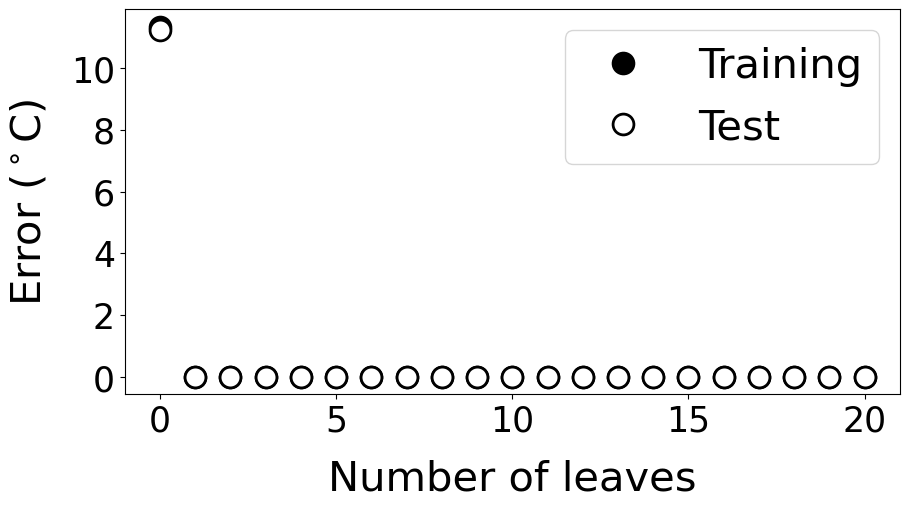

In [675]:
split_inds = np.arange(0,n_splits+1,1)
msize=15
medgewidth=2
plt.figure(figsize=(10,5))
plt.xticks([0,5,10,15,20],fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.plot(split_inds,np.sqrt(MSE_2015_splits),color="black",markersize=msize, 
                 marker='o', markeredgewidth=medgewidth,ls = 'None',markeredgecolor="black",
                 label="Training")
plt.plot(split_inds,np.sqrt(MSE_2016_splits),color="white",markersize=msize, 
                 marker='o',markeredgewidth=medgewidth, ls = 'None',markeredgecolor="black",
                 label="Test")
plt.ylabel(r'Error ($^\circ$C)',fontsize=font_size,labelpad = 15)
plt.xlabel(r'Number of leaves',fontsize=font_size,labelpad = 15)
plt.legend(fontsize=font_size)

for ind in range(n_splits+1):
    print(str(ind) + ' splits')
    print("RMSE 2015",np.sqrt(MSE_2015_splits[ind]))
    print("RMSE 2016",np.sqrt(MSE_2016_splits[ind]))

In [549]:
# plt.figure(figsize = (16,8)) 
# im = plt.imshow(temperature_grid_2015, cmap='gray', vmin=min_mean_temp, vmax=max_mean_temp,
#                 #extent=[0,n_hours,1, n_months+1],
#                 origin='lower', aspect='auto')
# if best_mse_month <= best_mse_hour:
#     print("Threshold month ",best_thresh_month)
#     plt.hlines(best_thresh_month-0.5,0-1,n_hours,ls='dashed',color='white',lw=5)
# else:
#     print("Threshold hour ",best_thresh_hour)
#     plt.vlines(best_thresh_hour-0.5,1-1,n_months,ls='dashed',color='white',lw=5)
# cbar = plt.colorbar(im)
# cbar.ax.tick_params(labelsize=font_size_ticks,pad = 20)
# cbar.set_label(label='Temperature (°C)',fontsize=font_size,labelpad = 20)
# plt.xticks(fontsize=font_size_ticks)
# plt.yticks(np.arange(0,n_months,1),np.arange(1,n_months+1,1).astype(str),fontsize=font_size_ticks) 
# plt.ylabel('Month',fontsize=font_size,labelpad = 10)
# plt.xlabel('Hour of the day',fontsize=font_size,labelpad = 15)
# plt.xlim([0-0.5,n_hours-0.5])
# plt.ylim([0-0.5,n_months-0.5])

# tree_estimate_split_1 = plt.zeros(temperature_grid_2015.shape)
# if best_mse_month <= best_mse_hour:
#     feature_split_1 = 0
#     thresh_split_1 = best_thresh_month
#     left_split_1 = temperature_2015[month_2015 <= best_thresh_month]
#     right_split_1 = temperature_2015[month_2015 > best_thresh_month]
#     tree_estimate_split_1[:(best_thresh_month-1),:] = np.mean(left_split_1)
#     tree_estimate_split_1[:(best_thresh_month-1),:] = np.mean(right_split_1)
# else:
#     feature_split_1 = 1
#     thresh_split_1 = best_thresh_hour
#     left_split_1 = temperature_2015[hour_2015 <= best_thresh_hour]
#     right_split_1 = temperature_2015[hour_2015 > best_thresh_hour]
#     tree_estimate_split_1[:best_thresh_hour,:] = np.mean(left_split_1)
#     tree_estimate_split_1[:best_thresh_hour,:] = np.mean(right_split_1)

# plt.figure(figsize = (16,8)) 
# im = plt.imshow(temperature_grid_2015, cmap='gray', vmin=min_mean_temp, vmax=max_mean_temp,
#                 #extent=[0,n_hours,1, n_months+1],
#                 origin='lower', aspect='auto')
# if best_mse_month <= best_mse_hour:
#     print("Threshold month ",best_thresh_month)
#     plt.hlines(best_thresh_month-0.5,0-1,n_hours,ls='dashed',color='white',lw=5)
# else:
#     print("Threshold hour ",best_thresh_hour)
#     plt.vlines(best_thresh_hour-0.5,1-1,n_months,ls='dashed',color='white',lw=5)
# cbar = plt.colorbar(im)
# cbar.ax.tick_params(labelsize=font_size_ticks,pad = 20)
# cbar.set_label(label='Temperature (°C)',fontsize=font_size,labelpad = 20)
# plt.xticks(fontsize=font_size_ticks)
# plt.yticks(np.arange(0,n_months,1),np.arange(1,n_months+1,1).astype(str),fontsize=font_size_ticks) 
# plt.ylabel('Month',fontsize=font_size,labelpad = 10)
# plt.xlabel('Hour of the day',fontsize=font_size,labelpad = 15)
# plt.xlim([0-0.5,n_hours-0.5])
# plt.ylim([0-0.5,n_months-0.5])

In [352]:
# if best_mse_month <= best_mse_hour:
#     inds_left = month_2015 <= best_thresh_month
#     inds_right = month_2015 > best_thresh_month
# else:
#     inds_left = hour_2015_2015 <= best_thresh_hour
#     inds_right = hour_2015 > best_thresh_hour
# [RMSE_vals_month_left,best_thresh_month_left,best_mse_month_left] = find_split(month_2015[inds_left],temperature_2015[inds_left],possible_thresholds_month,
#                                                                verbose)
# [RMSE_vals_hour_left,best_thresh_hour_left,best_mse_hour_left] = find_split(hour_2015[inds_left],temperature_2015[inds_left],possible_thresholds_hour,
#                                                                verbose)
# [RMSE_vals_month_right,best_thresh_month_right,best_mse_month_right] = find_split(month_2015[inds_right],temperature_2015[inds_right],possible_thresholds_month,
#                                                                verbose)
# [RMSE_vals_hour_right,best_thresh_hour_right,best_mse_hour_right] = find_split(hour_2015[inds_right],temperature_2015[inds_right],possible_thresholds_hour,
#                                                                verbose)

# plt.figure(figsize=(9,9))
# plt.xticks(fontsize=font_size_ticks) 
# plt.yticks(fontsize=font_size_ticks)
# plt.plot(possible_thresholds_month,RMSE_vals_month_left,color="black",lw=3)
# plt.plot(possible_thresholds_hour,RMSE_vals_hour_left,color="black",ls="dashed",lw=3)

# plt.figure(figsize=(9,9))
# plt.xticks(fontsize=font_size_ticks) 
# plt.yticks(fontsize=font_size_ticks)
# plt.plot(possible_thresholds_month,RMSE_vals_month_right,color="black",lw=3)
# plt.plot(possible_thresholds_hour,RMSE_vals_hour_right,color="black",ls="dashed",lw=3)


In [353]:
# plt.figure(figsize = (16,8)) 
# im = plt.imshow(temperature_grid_2015, cmap='gray', vmin=min_mean_temp, vmax=max_mean_temp,
#                 #extent=[0,n_hours,1, n_months+1],
#                 origin='lower', aspect='auto')
# if best_mse_month <= best_mse_hour:
#     print("Threshold month ",best_thresh_month)
#     plt.hlines(best_thresh_month-0.5,0-1,n_hours,ls='dashed',color='white',lw=5)
# else:
#     print("Threshold hour ",best_thresh_hour)
#     plt.vlines(best_thresh_hour-0.5,0-1,n_months,ls='dashed',color='white',lw=5)
# if best_mse_month_left <= best_mse_hour_left:
#     print("Threshold month left",best_thresh_month_left)
#     plt.hlines(best_thresh_month_left-0.5,0-1,n_hours,ls='dashed',color='white',lw=5)
# else:
#     print("Threshold hour left",best_thresh_hour_left)
#     plt.vlines(best_thresh_hour_left-0.5,0-1,n_months,ls='dashed',color='white',lw=5)
# if best_mse_month_right <= best_mse_hour_right:
#     print("Threshold month right",best_thresh_month_right)
#     plt.hlines(best_thresh_month_right-0.5,0-1,n_hours,ls='dashed',color='white',lw=5)
# else:
#     print("Threshold hour right",best_thresh_hour_right)
#     plt.vlines(best_thresh_hour_right-0.5,0-1,n_months,ls='dashed',color='white',lw=5)
# cbar = plt.colorbar(im)
# cbar.ax.tick_params(labelsize=font_size_ticks,pad = 20)
# cbar.set_label(label='Temperature (°C)',fontsize=font_size,labelpad = 20)
# plt.xticks(fontsize=font_size_ticks)
# plt.yticks(np.arange(0,n_months,1),np.arange(1,n_months+1,1).astype(str),fontsize=font_size_ticks) 
# plt.ylabel('Month',fontsize=font_size,labelpad = 10)
# plt.xlabel('Hour of the day',fontsize=font_size,labelpad = 15)
# plt.xlim([0-0.5,n_hours-0.5])
# plt.ylim([0-0.5,n_months-0.5])